# HR-VPP drought use case

In this notebook several drought indicators derived from the new CLMS service `High Resolution Vegetation Phenology and Productivity (HR-VPP)` will be developed. 
The aim is develop a `pan-European scale drought impact monitoring platform`. 


## Introduction

The HR-VPP data is distributed at 10m resolution and covers a Pan-European scale. In order to limit the computational power of the indicators and quickly identify locations with strong drought hazard during the growing season, some lower resolution datasets were used in the first place. For this the `MR-VPP phenology` dataset at 500 m resolution (2000-2019) and the `EDO Soil Moisture Anomaly (SMA)` Dataset developed by JRC at 5km resolution (2000-2020) are used. The combination of both datasets allows to derive some general drought indicators at 500 m resolution like drought intensity and hazard within the growing season. 

As a next step, the input information from drought indicators at 500m resolution allows to target areas that are under drought pressure. For these areas, `HR-VPP statistics` will be derived and aggregated within certain land covers and/or adiminstrative regions. On the other hand, the same kind of analysis could be done for the areas under no drought pressure, which will allow to analyze if there are clear statistical differences in HR-VPP indicators in comparison to normal conditions (no drought). Especially, emphasize will be put on the visualisation of the drought impact. 


---
**Before we start**

In the following cell we will install a couple of libraries in our EoXHub environement. These libraries are not essential for the workflow, but allow us to plot results on an interactive map.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install plotly folium 
!pip install sentinelhub --upgrade

     |████████████████████████████████| 201 kB 37.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 70.5 MB/s eta 0:00:01
  Created wheel for sentinelhub: filename=sentinelhub-3.4.1-py3-none-any.whl size=216197 sha256=ddf117a406d011cf9e938cee1fdbe4b0453a69a526ed44eeb92b3f3e4c184074
  Stored in directory: /home/jovyan/.cache/pip/wheels/db/a2/c4/9b920e0fb2a30ae287c21e54d921b37d79d3aba67fe0f3d262
Successfully built sentinelhub
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.1.2
    Uninstalling Pillow-8.1.2:
      Successfully uninstalled Pillow-8.1.2
  Attempting uninstall: sentinelhub
    Found existing installation: sentinelhub 3.4.0
    Uninstalling sentinelhub-3.4.0:
      Successfully uninstalled sentinelhub-3.4.0


## Library imports

In [2]:
#EDC
from edc import setup_environment_variables
# Sentinel Hub
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, BBox, bbox_to_dimensions)

# Xcube
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube

# Utilities
from pathlib import Path
import tarfile
import json
import datetime as dt
import os
import subprocess
from os import environ
import datetime

# Numerical computation
import numpy as np
import xarray as xr
import pandas as pd
from numba import jit

# Geospatial libraries
import rasterio as rio
import pyproj
from rasterio.mask import mask
import geopandas as gpd
import shapefile
from shapely.geometry import shape 
from shapely.geometry import Polygon
from osgeo import gdal
import rioxarray

# Plotting
import matplotlib.pyplot as plt
import folium

## Credential management
In EDC credentials are automatically setup. In the following cell we pass the crendentials to a dictionnary for `xcube` and to a Sentinel Hub `SHConfig` object for `sentinelhub-py`.

In [3]:
# Pass Sentinel Hub credentials to dictionnary
sh_credentials = dict(client_id=os.environ["SH_CLIENT_ID"],
                      client_secret=os.environ["SH_CLIENT_SECRET"])
setup_environment_variables()
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:



## Area of interest

Before comparing the two workflows, we will select an Area Of Interest (AOI) that will be used in both examples. The next cells define the bounding box of our AOI and plot it on an interactive map.

In [4]:
# Bounding box in EPSG 3035
aoi_coords = (3893000,3113000,3900000,3115000)#(3893000, 3105416, 3900000, 3110000)

In [5]:
# For plotting the extent on a map, convert to EPSG:4326
proj_to_WGS = pyproj.Transformer.from_crs(3035, 4326, always_xy=True)
proj_to_LAEA  = pyproj.Transformer.from_crs(4326,3035, always_xy = True)

aoi_coords_degrees = (proj_to_WGS.transform(aoi_coords[0], aoi_coords[1]),
                      proj_to_WGS.transform(aoi_coords[2], aoi_coords[3]))
aoi_coords_degrees = (aoi_coords_degrees[0][0],aoi_coords_degrees[0][1],aoi_coords_degrees[1][0],aoi_coords_degrees[1][1])

aoi_coords_LAEA =  (proj_to_LAEA.transform(aoi_coords_degrees[0], aoi_coords_degrees[1]),
                      proj_to_LAEA.transform(aoi_coords_degrees[2], aoi_coords_degrees[3])) #update the LAEA coordinates to the same cornes as defined for degrees

aoi_coords_LAEA  = (aoi_coords_LAEA[0][0],aoi_coords_LAEA[0][1],aoi_coords_LAEA[1][0],aoi_coords_LAEA[1][1])
# Get center point to centre the map
aoi_centre = [(aoi_coords_degrees[1] + aoi_coords_degrees[3])/2,
              (aoi_coords_degrees[0] + aoi_coords_degrees[2])/2]

# Make map
m = folium.Map(aoi_centre, zoom_start=8,tiles='cartodbpositron')

# Plot AOI on the map
folium.Rectangle(
    bounds=[(aoi_coords_degrees[1],aoi_coords_degrees[0]),(aoi_coords_degrees[3],aoi_coords_degrees[2])],
    line_join="round",
    dash_array="5, 5",
    
).add_to(m)

# Display
m

## Specify Sentinel Hub collection ID of ingested datasets

All the necessry collections for the drought use case were ingested by Sentinel Hub services making them accessible in the same way as standard satellite data collections. To access these collections, we need to specify the private collection ID.

In [6]:
# Collection ids
EEA_Soil_Moisture_collection = "8a2e3e0d-7879-4fd8-8a6d-98f51c8056b2" #SMA from JRC
EEA_timesat_collection = "e541af9d-a9f4-4aba-8952-e5d2a73fcb0d" #MR-VPP phenology at 500m resolution
CLC_collection_id ="cbdba844-f86d-41dc-95ad-b3f7f12535e9" #Corine Land Cover layer
NUTS3_collection_id = "13e6e773-b2bc-49c7-8745-d7c74bdcaeb1" #NUTS level 3 layer
vi_collection = "472c0398-430d-4157-a62d-603363d7a4e8" # HR-VPP vegetation indices
st_collection = "90f0abac-87cf-4277-958b-d8c56d9e5371" #  HR-VPP seasonal trajectories
vpp_s1_collection = "67c73156-095d-4f53-8a09-9ddf3848fbb6" # HR-VPP season 1
vpp_s2_collection = "8c2bc96a-3c2c-482b-9394-031310171b33" # HR-VPP season 2

## Specify the years of interest

Below the user should define for which years, the cubes should be generated to perform the drought monitoring.

In [7]:
years_range = [2012,2020] #options between 2000-2020. Keep in mind that the HR-VPP data only covers the period 2017-2020 
years_names = list(np.arange(years_range[0],years_range[-1]+1,1))
if years_range[-1] == 2020: # this is needed because the MR-VPP has no data in 2020
    years_range_excl_2020 = [years_range[0],2019]
    years_names_excl_2020 = list(np.arange(years_range_excl_2020[0],years_range_excl_2020[-1]+1,1))

#### SPECIFY OUTPUT FOLDER WITH RESULTS

In [8]:
output_folder_csv = Path("./{}/{}".format('output', 'csv'))
os.makedirs(output_folder_csv, exist_ok= True)

# Section 1: Load SMA with xcube <a id='xcube'></a>

In this section we will use the xcube library to build cube and process the SMA data.

In [9]:
def create_xcube_data(band_names, aoi_coords, proj_code, time_period, collection_id, sh_credentials, time_range, spatial_res = 10, creodias = False, datatype  = 'UINT16'):
    """Create a datacube from a certain collection ID. This datacube will be clipped to a certain bounding box. 
     
    :param band_names: list of bands that need to be requested for the collection #check the documentation to know the available bands. 
    :type band_names: list
    :param aoi_coords: 4 corner coordinates in the projection (see param: 'proj_code') for which the data should be requested 
    :type aoi_coords: tupe with ints or floats
    :param proj_code : url to the projection code in which the datacube should be delivered
    :type proj_code: str
    :param time_period: the temporal resolution in which the datacube should be delivererd e.g.'1Y' (one layer each year)
    :type time_period: str
    :param collection_id: the ID of the collection in the EDC to get access to it
    :type collection_id: str
    :param sh_credentials: EDC credentials to access the collection
    :param time_range: the time range for which the data should be requested
    :type time_range: list with str of time range e.g. [2018-01-01,2018-12-31]
    :param spatial_res (optional): the spatial resolution in which the data should be resampled. 
    :type  spatial_res: int
    :param creodias (optional): define if the requested data originates from creodias (as is the case for HR-VPP data)
    :type creodias: boolean
    :param datatype: specify in which format the output values should be delivered
    :type datatype: str
    
    
    :return: datacube with the loaded collection 
    :rtype: Xarray dataset
    """
        
    cube_config = CubeConfig(dataset_name='CUSTOM',
                         band_names=band_names,
                         bbox=aoi_coords,
                         crs = proj_code,
                         time_range= time_range,
                         time_period=time_period,
                         spatial_res=spatial_res,
                         band_sample_types=datatype,
                         collection_id=collection_id
                         )
    
    if creodias:
        out_cube = open_cube(cube_config, **sh_credentials, api_url="https://creodias.sentinel-hub.com")
    else:
        out_cube = open_cube(cube_config, **sh_credentials)
  
    return out_cube


#### Specify projection and resolution of collection

Based on the previously determined bounding box, we set the projection for the datacubes and their spatial resolution.

In [10]:
projection_code_LAEA = "http://www.opengis.net/def/crs/EPSG/0/3035"
# Spatial resolution in the units of the projection
spatial_res_SMA_MRVPP = 500  # in meters since LAEA projection
spatial_res_CLC = 100 # original resolution of the CLC dataset
spatial_res_HRVPP = 10

### Setup the Timesat datacube

The timesat collection (which includes the SOS and EOS datasets) contains a dataset for each year. The date is set by default to the 1st January. Here, we will request the `sos` and `eos` bands from the collection for the defined years. 

In [11]:
# SOS and EOS
time_range = ['{}-01-01'.format(years_names[0]), '{}-12-31'.format(years_names[-1])]
time_period = '1d'
band_names = ['sos', 'eos']
timesat_xcube = create_xcube_data(band_names, aoi_coords_LAEA, projection_code_LAEA, time_period, EEA_timesat_collection, sh_credentials, time_range, spatial_res = spatial_res_SMA_MRVPP)

### Setup the SMA datacube

We request the `anomaly` band of the SMA dataset. Because the season can start the previous year for some of the pixels, we widen the range for the year by querying part of the year before the first year of interest . The index values are retrieved as floats.

In [12]:
# SMA
#In case the year 2000 is requested do not go the previous year!
if years_range[0] == 2000:
    start_date = '{}-01-01'.format(str(years_range[0]))
else:
    start_date = '{}-07-01'.format(str(years_range[0]-1))
end_date = '{}-12-31'.format(str(years_range[-1]))
time_range = [start_date, end_date]
band_names = ['anomaly']
datatype = 'FLOAT32'
sma_xcube = create_xcube_data(band_names, aoi_coords_LAEA, projection_code_LAEA,  time_period,EEA_Soil_Moisture_collection, sh_credentials, time_range, 
                              spatial_res = spatial_res_SMA_MRVPP, datatype = datatype)

### Set nodata values

The `1d` time_period parameter returns a band for each day in the time-range: `xcube` does not filter the dates for which data is present. Therefore we will remove the timeslices without any data. This operation will take a bit of time: because we are manipulating the data for the first time, the cube has to be computed first.

For the Timesat cube, this step can be performed faster by preselecting the 1st January.

In [13]:
# Select January the first only
timesat_xcube = timesat_xcube.where((timesat_xcube.time.dt.month == 1) & (timesat_xcube.time.dt.day == 1), drop=True)

# Set 0 as nodata values
timesat_xcube = timesat_xcube.where(timesat_xcube['sos'] != 0)  

# Remove nodata values
timesat_xcube = timesat_xcube.dropna("time", how="all")

For the SMA cube, the processing takes longer because the time-slices with data are distributed across the years and the nodata filter has to check every day over the years.

In [14]:
# A trick to reduce the amount of data since SMA is every 10 days
sma_xcube = sma_xcube.where((sma_xcube.time.dt.day == 1) | (sma_xcube.time.dt.day == 11) | (sma_xcube.time.dt.day == 21) | (sma_xcube.time.dt.day == 31), drop=True)

sma_xcube = sma_xcube.dropna("time", how="all")

#### Check the xcubes

In the next three cells the first time slice of the datasets are plotted for visual inspection.

**Soil Moisture Anomaly**

Note that the pixel size appears larger because the Soil Moisture Anomaly resolution is 5 km. Because we are creating a datacube with a higher resolution (500m) the data is resampled.

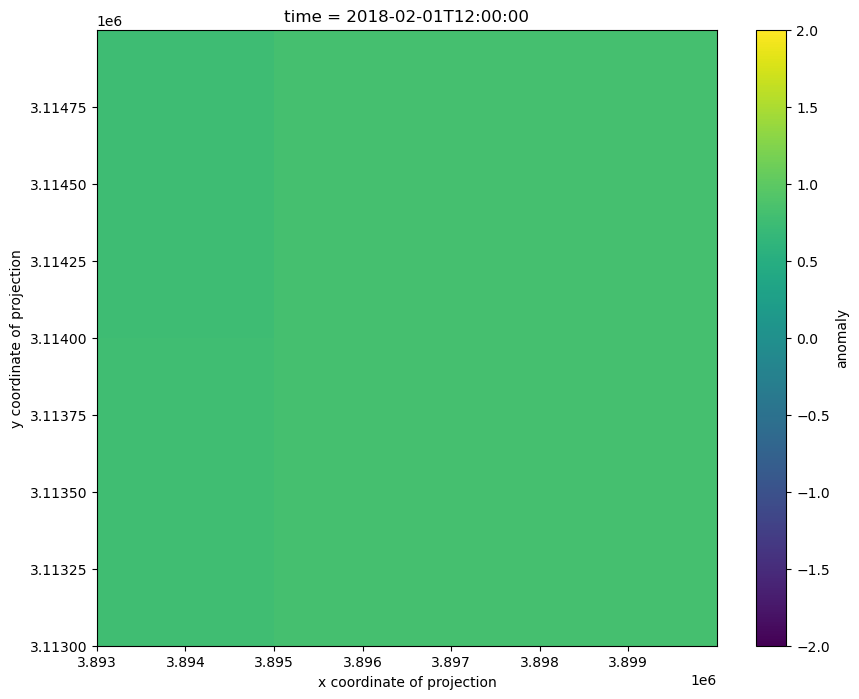

In [75]:
sma_xcube["anomaly"].sel(time='2018-02-01 12:00:00', method='nearest').plot.imshow(figsize=(10,8), vmin=-2, vmax=2)
plt.show()

**Start of Season**

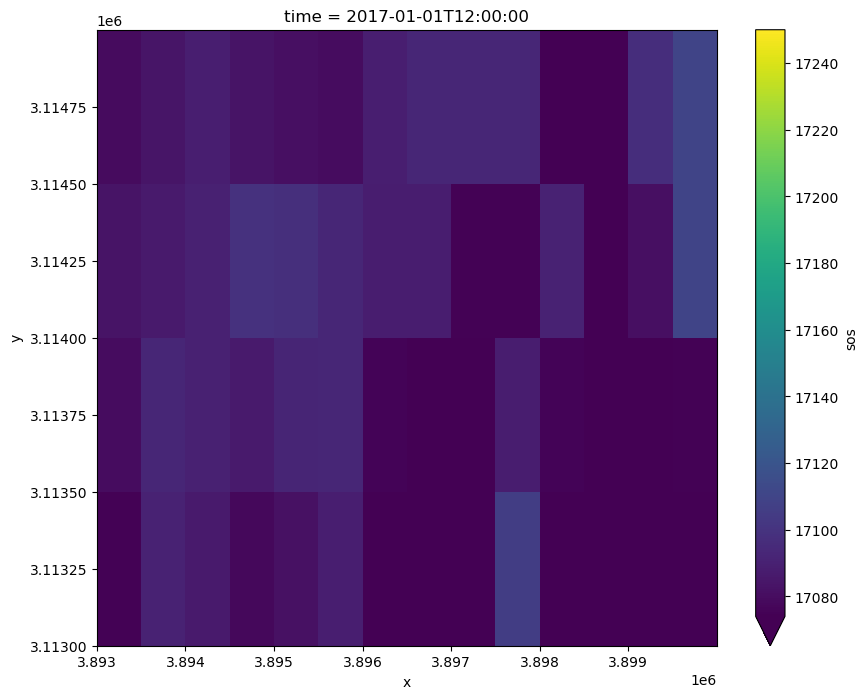

In [77]:
timesat_xcube["sos"].sel(time='2017-01-01 12:00:00', method='nearest').plot.imshow(figsize=(10,8), vmin=17074, vmax=17250)
plt.show()

**End of Season**

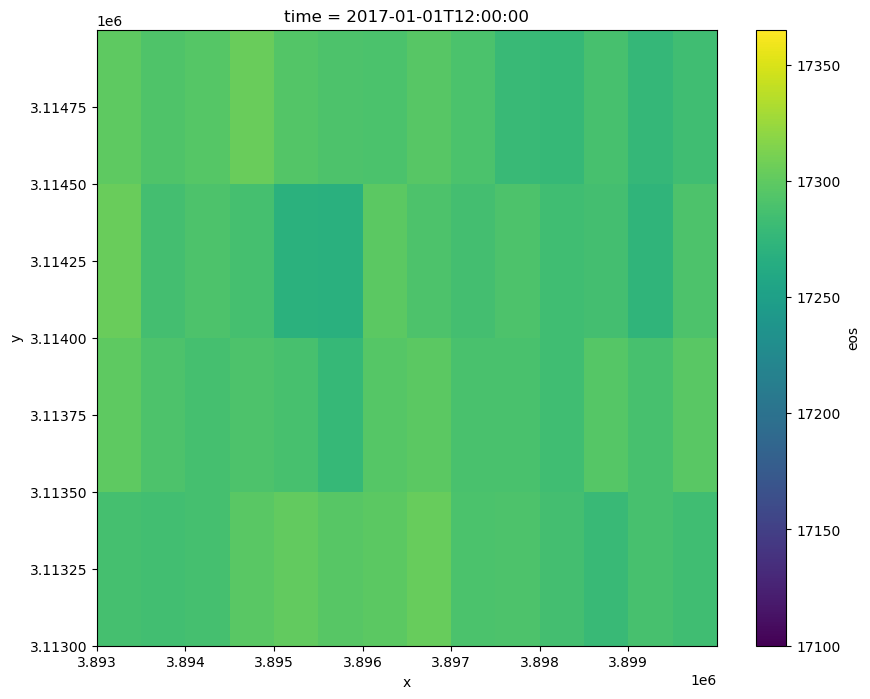

In [78]:
timesat_xcube["eos"].sel(time='2017-01-01 12:00:00', method='nearest').plot.imshow(figsize=(10,8), vmin = 17100, vmax=17365)
plt.show()

### Helper functions

In the next cell we define a few functions to manipulate the data collections, this includes manipulating dates, finding positions in the data collections and filtering the data.

In [18]:
def yydoy_to_date(datacube, yydoy_variable, new_var_name, years_interest):
    """YYDOY to DOY.
    
    Converts a datacube variable containing YYDOY dates to Day Of Year values.
    If the date is in the previous year, the DOY is a negative value.
    """
    # Compute the array of sos and initialise an empty array
    data = datacube[yydoy_variable].compute().data
    out_dates = np.zeros_like(data)
    
    # Loop over values in array to convert the YYDOY format to dates
    for h in range(data.shape[0]): #loop also over the years
        current_year = int(years_interest[h])
        for i in range(data.shape[1]):
            for j in range(data.shape[2]):
                if not np.isnan(data[0,i,j]):
                    if current_year >= 2010 and len(str(data[h, i, j])) > 4:
                        year = int(str(int(data[h, i, j]))[0:2])
                        doy = int(str(int(data[h, i, j]))[2:])                       

                    elif current_year == 2000 or len(str(data[h, i, j])) < 4:
                        year = 0
                        doy = int(str(int(data[h, i, j]))[:])

                    else:
                        year = int(str(int(data[h, i, j]))[0:1])
                        doy = int(str(int(data[h, i, j]))[1:])
                        

                    # Here we remove wrong dates created by interpolation
                    if doy <= 365:
                        lastdigits_year = int(str(current_year)[2:])
                        lastdigits_prev_year = int(str(current_year-1)[2:])

                        if year == lastdigits_year:                      
                            out_dates[h, i, j] = doy 
                        elif year == lastdigits_prev_year:
                            out_dates[h, i, j] = doy - 365
                        else:
                            out_dates[h, i, j] = np.nan

                    else:
                        out_dates[h, i, j] = np.nan
    
    datacube[new_var_name] = xr.DataArray(out_dates, dims=['time','y', 'x'], name=new_var_name)
    
def nearest(items, pivot, method=None):
    """Get nearest date.
    
    Fetch nearest date in items, based on pivot. If method is "upper", and the pivot is larger
    than the max value in items, it returns the max of items. If method is "lower" and the pivot is smaller
    than the min value of items, it returns the min of items.
    
    :param items: list of values
    :type items: list
    :param pivot: value to compare to list
    :type pivot: int or float
    :param method: method for values out of bounds
    :type: str (optional)
    :return: nearest value in items
    :rtype: int or float
    """
    # Check for method used
    if (method != "upper" and method != "lower"):
        raise ValueError("Wrong method specified, use upper or lower.")
        
    elif method == "upper":
        if pivot > max(items):
            nrst = max(items)
        else:
            nrst = min([ i for i in items if i >= pivot], key=lambda x:abs(x-pivot))
    else:
        if pivot < min(items):
            nrst = min(items)
        else:
            nrst = min([ i for i in items if i <= pivot], key=lambda x:abs(x-pivot))

    return nrst
 
    
@jit(nopython=True)
def mean_slice(input_array, start_index, end_index, method="mean"):
    """Get mean slice of a 3D array.
    
    Fetch the average of a 3D array (1st dimension) based on start and
    end indices defined in two arrays of the same shape as a slice of the
    3D array.
    
    :param input_array: 3D array to be averaged on the 1st axis
    :type input_array: numpy.ndarray
    :param start_index: array containing start indices
    :type start_index: numpy.ndarray
    :param end_index: array containing end indices
    :type end_index: numpy.ndarray
    :return: Arrays containing average input_array along 1st dimension
    :rtype: numpy.ndarray
    
    """
    if not method in ["mean", "std"]:
        raise ValueError("Wrong method of calculation.")

    # Check size of arrays
    if (input_array[0, :, :].shape != start_index.shape or
        input_array[0, :, :].shape != end_index.shape):
        raise AssertionError("Index arrays not the right shape!")
    
    # Initialise array continaing results
    mean_array = np.zeros_like(start_index).astype(np.float32)
    
    # Loop over 3D raster to calculate the average between indices on axis 0
    for i in range(0, start_index.shape[0]):
        for j in range(0, start_index.shape[1]):
            if (np.isnan(start_index[i, j]) or np.isnan(end_index[i, j] or start_index[i, j] == end_index[i, j])):
                mean_array[i, j] = np.nan
            else:
                if method == "mean":
                    mean_array[i, j] = np.nanmean(input_array[start_index[i, j]: end_index[i, j], i, j])
                else:
                    mean_array[i, j] = np.nanstd(input_array[start_index[i, j]: end_index[i, j], i, j])

    return mean_array
        

def sampling_period_from_sos_to_eos(cube_dates, timesat_cube, method = 'XCUBE'):
    """Get indices in the SMA cube based on SOS&EOS dates over the different years.
    :param cube_dates: list of all SMA observations
    :type input_array: numpy.ndarray
    :param timesat_cube: Xarray dataset containing all SOS/EOS values over the years
    :type timesat_cube: Xarray dataset
    :param method: Define if the input datacube is an XCUBE or not
    :return: Update of the timesat cube with now info on the start + end index to map SMA over the growing season for each year
    :rtype: Xarray dataset
    
    """
       
    # Convert dates from time variable to DOY
    dates = pd.DatetimeIndex(cube_dates)
    if  min(pd.DatetimeIndex(cube_dates)).year == 2000:
        year_2000_incl = True
    else:
        year_2000_incl = False
        
    SOS_ind_dates = np.zeros_like(timesat_cube['sos_doy_3m'])
    EOS_ind_dates = np.zeros_like(timesat_cube['eos_doy'])
  
        

    for time in range(SOS_ind_dates.shape[0]): #loop over the years
        dates_doy = []
        
        sos_values = timesat_cube.isel(time = time)["sos_doy_3m"].data 
        eos_values = timesat_cube.isel(time = time)["eos_doy"].data 
       
            
        if time == 0 and year_2000_incl:
            sos_values_flattened = [item if not item <0 else 1 for item in sos_values.flatten()]
        else:
            sos_values_flattened = sos_values.flatten()

        sos_values_flattened = [item if not  item == 0 else np.nan for item in sos_values_flattened] #otherwise error -> need to be investigated!!!

            
        year = pd.DatetimeIndex([timesat_cube.time.data[time]]).year[0]
        for date in dates:
            if date.year == year :
                dates_doy.append(date.timetuple().tm_yday)
            elif date.year == year -1:
                dates_doy.append(date.timetuple().tm_yday -  365)
            else:
                dates_doy.append(np.nan)

        # Calculate the index of the eos date
        SOS_ind_dates[time,:,:] = np.reshape(np.array([dates_doy.index(nearest(dates_doy, x, "lower")) if not np.isnan(x) else np.nan for x in sos_values_flattened]), sos_values.shape)

        # Calculate the index of the eos date
        EOS_ind_dates[time,:,:] = np.reshape(np.array([dates_doy.index(nearest(dates_doy, x, "lower")) if not np.isnan(x) else np.nan for x in eos_values.flatten()]), eos_values.shape)
    
    if method == "XCUBE":
        timesat_cube['SOS_start_ind'] = xr.DataArray(SOS_ind_dates, dims=['time','y', 'x'], name='SOS_start_ind')
        timesat_cube['EOS_start_ind'] = xr.DataArray(EOS_ind_dates, dims=['time','y', 'x'], name='EOS_start_ind')
    else:
        timesat_cube['SOS_start_ind'] = xr.DataArray(SOS_ind_dates, dims=['time','lat', 'lon'], name='SOS_start_ind')
        timesat_cube['EOS_start_ind'] = xr.DataArray(EOS_ind_dates, dims=['time','lat', 'lon'], name='EOS_start_ind')
        
   

def write_raster(aoi_coords,input_cube, datatype, outname_raster, years_names, band_spec, multi_yrs = True, multi_obs_yr = False, EPSG = '3035'):
    """Write values in a datacube to a raster and store it locally. 
    :param: aoi_coords: the 4 corner coordinates in the EPSG of the datacub
    :param input_cube: Xarray dataarray or numpy ndarray containing the data that should be written into a raster
    :param datatype: The datatype in which the raster should be written. This datatype should correspond with the datatype in the input_cube
    :param outname_raster: The name of the raster file.
    :param years_names: the name of the years for which data is available (only needed in case multiyrs data should be written into the raster)
    :param band_spec: Naming of the band that should be used
    :param multi_yrs: indicates if the data this should be written is for a single time stamp or multitimestamps (default is True)
    :param multi_obs_ry: Indicates if the datacube contaings multiple observation per year or not
    :param EPSG: the number of the projection in which the raster should be written
    :return: A written raster in the desired folder
    """
    output_folder_raster = Path("./{}/{}".format('output', 'rasters'))
    os.makedirs(output_folder_raster, exist_ok= True)
        
    if EPSG == '4326':
        transform = rio.transform.from_bounds(aoi_coords[0], aoi_coords[1], aoi_coords[2], aoi_coords[3], input_cube.lon.size, input_cube.lat.size)
    else:
        transform = rio.transform.from_bounds(aoi_coords[0], aoi_coords[1], aoi_coords[2], aoi_coords[3], input_cube.x.size, input_cube.y.size)

        
    if multi_yrs and not multi_obs_yr:
        count = len(years_names)
    elif multi_yrs and multi_obs_yr:
        count = len(input_cube.time)
    else:
        count  = 1
    
    if EPSG == '4326':

        profile = {'driver': 'GTiff', 'height':input_cube.lat.size, 'width': input_cube.lon.size, 'count': count, 'dtype': datatype, 'transform': transform} 
    else:
        profile = {'driver': 'GTiff', 'height':input_cube.y.size, 'width': input_cube.x.size, 'count': count, 'dtype': datatype, 'transform': transform} 
        
    with rio.open(os.path.join(output_folder_raster.absolute().as_posix(),'{}.tif'.format(outname_raster)),'w', crs = 'EPSG:{}'.format(EPSG), **profile) as dst:
        if multi_yrs or multi_obs_yr:
            for ix in range(count):
                dst.write(input_cube[ix,:,:].astype(datatype), ix+1)
                if multi_obs_yr:
                    dst.set_band_description(ix+1, '{} {}'.format(pd.to_datetime(input_cube.time.data[ix]).strftime('%Y-%m-%d'), band_spec))
                else:
                    dst.set_band_description(ix+1, '{} {}'.format(str(years_names[ix]), band_spec))
        
        else:
            dst.write(input_cube, 1)
            dst.set_band_description(1, '{}'.format(band_spec))   
            
            
def interpolate_xarray(cube_new_res, cube_to_resample):
    """Write values in a datacube to a raster and store it locally. 
    :param: cube_new_res: the datacube containing the x,y coordinates to which should be resampled
    :param cube_to_resample: the cube which will have to be resampled to the new resolution
    :return: A resampled datacube
    """
    new_lon = cube_new_res.x.values
    new_lat = cube_new_res.y.values
    cube_resampled = cube_to_resample.interp(y = new_lat, x = new_lon, method = 'nearest')
    return cube_resampled

### Filter Soil Moisture Anomaly data

Following the instructions in the proposal, we set a "cutoff" function for SMA values to +3 and -3.

In [19]:
# Filter values larger than 3 and smaller than -3
filter_step_1 = sma_xcube["anomaly"].where(sma_xcube["anomaly"]<=3, 3)
filter_step_2 = filter_step_1.where(filter_step_1 >=-3, -3)

sma_xcube["anomaly_filtered"] = filter_step_2

In [20]:
#write the SMA to a raster
outname_raster = 'SMA' 
datatype = rio.float32
band_spec = 'SMA'
write_raster(aoi_coords_LAEA, sma_xcube['anomaly_filtered'], datatype, outname_raster, years_names,band_spec, multi_obs_yr= True)

### Convert SOS and EOS
In the next cell we will create a new variable in the timesat datacube which represents the DOY relative to the start of the chosen year. This means that dates for the year before will be negative. As we have multiple years of interest, we will loop through the years.

In [21]:
yydoy_to_date(timesat_xcube, "sos", "sos_doy", years_names)
yydoy_to_date(timesat_xcube, "eos", "eos_doy", years_names)

In the following cell we will extend the SOS to SOS-3 months. For the time being we cut a corner by simply substracting 90 days to the SOS (very approximate method). 

In [22]:
# Remove 3 months for simplicity we consider 3 months = 30 days
timesat_xcube["sos_doy_3m"] = timesat_xcube["sos_doy"] - 90

### Compute indices of growing season for each pixel

In this step we will compute the indices of SOS-3months and EOS for each pixel in the SMA datacube. This is needed to delineate the growing season for each pixel in the SMA datacube

In [23]:
sampling_period_from_sos_to_eos(sma_xcube.time.data,timesat_xcube)

### Plot the data for a given location

In the next cell we will plot the SMA values throughout the season as bars for a given pixel pair.

In [24]:
def plot_pixel_time_series(cube, x_pixel, y_pixel, year, years_names, cube_sos_eos):
    """Plot the SMA values during the growing season of a specific pixel and for a certain year.
    :param: cube: the datacube with the SMA values
    :param x_pixel: x pixel ID used for plotting
    :param y_pixel: y pixel ID used for plotting
    :param year: the year for which it should be plotted
    :param years_names: the name of the years for which data is available
    :param cube_sos_eos: datacube containing the start and end index to define the growing season with the SMA cube
    :return: A temporal plot of the SMA values of a certain pixel
    """
    
    index_year_cube = years_names.index(year)
    start_ind_year = cube_sos_eos.isel(time = index_year_cube)['SOS_start_ind'][x_pixel, y_pixel].values
    end_ind_year = cube_sos_eos.isel(time = index_year_cube)['EOS_start_ind'][x_pixel, y_pixel].values
    
    
    if np.isnan(start_ind_year) or np.isnan(end_ind_year):
        print('NO SEASON FOR THIS YEAR')
        return None
    
    start_ind_year = int(start_ind_year)
    end_ind_year  = int(end_ind_year)
    
    SMA_values_pixel_season = cube['anomaly_filtered'][start_ind_year: end_ind_year+1, x_pixel, y_pixel]
    
    doys = [x.timetuple().tm_yday if x.year == year else x.timetuple().tm_yday-365 for x in pd.DatetimeIndex(SMA_values_pixel_season.time.data)]

    
    fig, ax = plt.subplots(figsize=(12,8))
    
    ax.bar(doys, SMA_values_pixel_season.values,width=5)
    ax.set_ylim(-2, 2)
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("Soil Moisture Anomalies (Standardised)")
    ax.set_title("SMA during the growing season of {}".format(str(year)))
    plt.show()

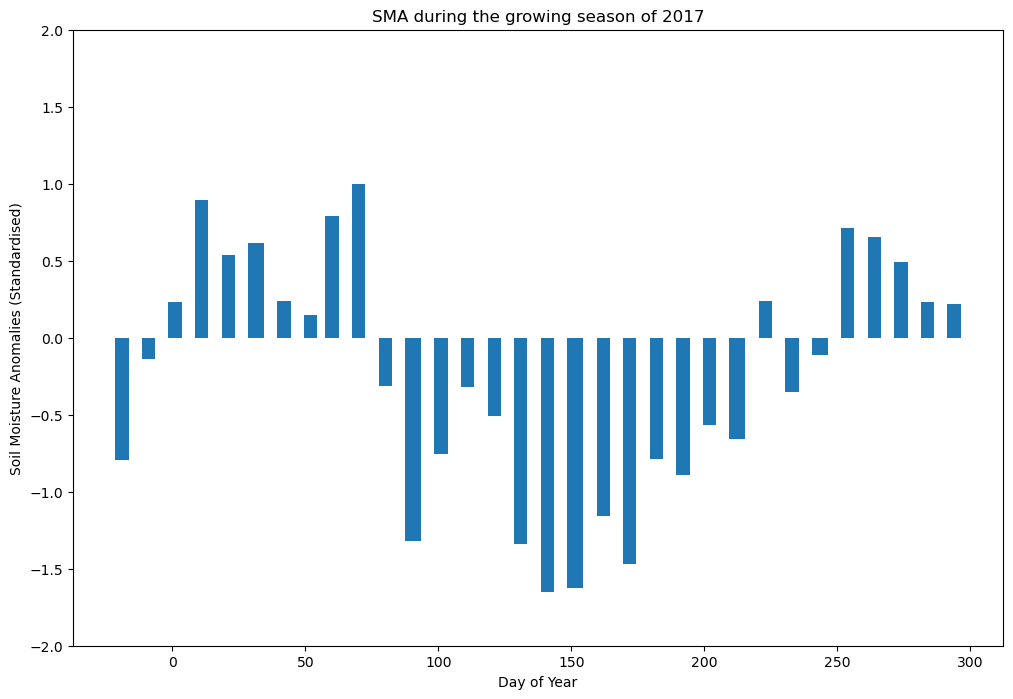

In [25]:
year_Z_score_plotting = 2017
plot_pixel_time_series(sma_xcube, 0, 0, year_Z_score_plotting, years_names, timesat_xcube)

# Section 2: Load SMA with sentinelhub-py  <a id='shpy'></a>



In this section we will use the `sentinelhub-py` library to build a cube and process the SMA data.

## Evalscript

At the heart of Sentinel Hub services lies the Evalscript. An evalscript (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. 

In this case we willreturn the following bands:

- SMA: Soil Moisture Anomalies (dataset from JRC)
- SOS: the start of season -3 months in DOY (relative to the current year)
- EOS: then end of season in DOY (relative to the current year)

In [26]:

evalscript = """
//VERSION=3

function setup () {
    return {
      input: [
        {
          datasource: 'SM',
          bands: ['anomaly']
        },
        {
          datasource: 'TIMESAT',
          bands: ['sos', 'eos']
        }
      ],
      output: [{
        id: "anomaly",
        bands: 1,
        sampleType: SampleType.FLOAT32},
      {
        id: "sos_doy_3m",
        bands: 1,
        sampleType: SampleType.FLOAT32},
      {
        id: "eos_doy",
        bands: 1,
        sampleType: SampleType.FLOAT32}
      ],
      mosaicking: 'ORBIT'
    }
  }
  
  function updateOutput (outputs, collection) {
    // Update the bands for SMA and Z
    const subset = ({anomaly} = outputs, {anomaly})
    const subset2 = ({sos_doy_3m, eos_doy} = outputs, {sos_doy_3m, eos_doy})
  
    Object.values(subset).forEach(output => {
      output.bands = collection.SM.scenes.length
      }
    )
     Object.values(subset2).forEach(output => {
      output.bands = collection.TIMESAT.scenes.length
      }
    )
    
  }
  
  
  
  function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
    // Write dates to a json, useful to get the dates
    var all_dates = []
    for (let i=0; i < scenes.SM.scenes.length; i++){
      all_dates[i] = JSON.stringify(scenes.SM.scenes[i].date)
    }
    outputMetadata.userData = {"dates":  all_dates}
  }
  
  
  function evaluatePixel (samples, scenes) {
    // Fetch objects containing dataset content
    const anomalyScenes = scenes.SM.scenes
    const anomalyValues = samples.SM
    const timesatScenes = scenes.TIMESAT.scenes
    const timesatValues = samples.TIMESAT
  
    // Final output where we store all z values for each year.
    // -9999 is the nodata value assigned.
    var SMAinGrowingSeason = new Array(anomalyValues.length).fill(-9999)
    var SOSvaluesyears = new Array(timesatValues.length).fill(-9999)
    var EOSvaluesyears = new Array(timesatValues.length).fill(-9999)

  
    // Loop over the different years for storing SOS/EOS values
    for (let k = 0; k < timesatValues.length; k++){
         // Get the timesat values for a single year
        const { sos, eos } =timesatValues[k]

        // Check if sos and eos are invalid values (0).
        const hasNoSeason = !sos && !eos
        const zeroSeason = sos === eos

        if (!(hasNoSeason || zeroSeason)) {
          // Timesat date
          const selectedYear = timesatScenes[k].date

          // Date for the SOS pixel
          const sosAsDate = parseSeasonAsDate(sos, selectedYear)

          // Date for the EOS pixel
          const eosAsDate = parseSeasonAsDate(eos, selectedYear)

          // Month of the SOS date
          const month = sosAsDate.getMonth()

          // Get SOS three months before SOS.
          sosAsDate.setMonth(sosAsDate.getMonth() - 3) 
          while (sosAsDate.getMonth() === month) {
            sosAsDate.setDate(sosAsDate.getDate() - 1)
          }

          // Get YYDOY of SOS - 3 months
          const sosThreeMonthsAgo = parseDateAsSeason(sosAsDate)

          var rel_sos = relative_doy(sosAsDate, selectedYear.getFullYear())
          SOSvaluesyears[k] = rel_sos
          var rel_eos = relative_doy(eosAsDate, selectedYear.getFullYear())
          EOSvaluesyears[k] = rel_eos
        }


        }    

        

      // Loop over the soil moisture anomaly within the growing season
      for (let i = 0; i < anomalyValues.length; i++) {
        var anomalyValue = anomalyValues[i].anomaly

        // Threshold the anomaly values
        if (anomalyValue < -3) {
          anomalyValue = -3
        }
        if (anomalyValue > 3) {
          anomalyValue = 3
        }

        SMAinGrowingSeason[i] = anomalyValue
      }


    return {
        anomaly: SMAinGrowingSeason,
        sos_doy_3m: SOSvaluesyears,
        eos_doy: EOSvaluesyears,
    }
  }
  
  function datediff (first, second) {
    // Take the difference between the dates and divide by milliseconds per day.
    // Round to nearest whole number to deal with DST.
    return Math.round((second - first) / (1000 * 60 * 60 * 24))
  }
  
  
  function parseSeasonAsDate (season, year) {
    const selectedYear = year.getFullYear()
    if (selectedYear === 2000) {
      if (season.toString().length > 3) {
        return new Date('2000-01-01')
      }
      return getDateFromDay(2000, season)
    }
  
    if (selectedYear === 2001) {
      const firstDigitOfYear = parseInt(season.toString().slice(0, 1))
      if (firstDigitOfYear !== 1) {
        return getDateFromDay(2000, season)
      }
    }
  
    if (selectedYear < 2010 || season.toString().length  == 4) {
      const day = season.toString().slice(1)
      const lastDigitOfYear = season.toString().slice(0, 1)
      const seasonYear = parseInt(`200${lastDigitOfYear}`, 10)
      return getDateFromDay(seasonYear, day)
    }
  
    const day = season.toString().slice(2)
    const lastDigitsOfYear = season.toString().slice(0, 2)
    const seasonYear = parseInt(`20${lastDigitsOfYear}`, 10)
    return getDateFromDay(seasonYear, day)
  }
  
  function relative_doy(inDate, baseYear){
    // From a date compute relative DOY compared to
    // 1st January of a given year
    var now = new Date(inDate.getFullYear(), inDate.getMonth(), inDate.getDay())
    var start = new Date(baseYear, 0, 0);
    var diff = now - start;
    var oneDay = 1000 * 60 * 60 * 24;
    var day = Math.floor(diff / oneDay);
    
    return day
  }
  
  function getDateFromDay (year, day) {
    const date = new Date(year, 0) // initialize a date in `year-01-01`
    return new Date(date.setDate(day)) // add the number of days
  }
  
  
  function parseDateAsSeason (date) {
    const selectedYear = date.getFullYear()
    const dayOfYear = dateToDayOfYear(date)
    if (selectedYear === 2000) {
      return dayOfYear 
    }
  
    if (selectedYear < 2010) {
      const formattedYear = selectedYear.toString().slice(3, 4)
      return parseInt(`${formattedYear}${dayOfYear}`, 10)
    }
  
    const formattedYear = selectedYear.toString().slice(2, 4)
    return parseInt(`${formattedYear}${dayOfYear}`, 10)
  }
  
  function dateToDayOfYear (date) {
    var start = new Date(date.getFullYear(), 0, 0)
    var diff =
      date -
      start +
      (start.getTimezoneOffset() - date.getTimezoneOffset()) * 60 * 1000
    var oneDay = 1000 * 60 * 60 * 24
    var day = Math.floor(diff / oneDay)
    return day
  }
"""

## AOI

Based on the common AOI defined at the start of this Jupyter Notebook, we will create a `sentinelhub-py` object that will be passed to the request.

In [27]:
# Bounding box
aoi_bbox = BBox(bbox=aoi_coords_LAEA, crs="EPSG:3035")
# Resulting image size
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=spatial_res_SMA_MRVPP)

## Outputs

We will return the Sentinel Hub results as tiffs in order to convert them to a datacube. Here we set the output folder that will contain the results.

In [28]:
output_folder = Path("./Z_data")

## Request

To send the Evalscript to Sentinel Hub services we need to specify a certain number of input parameters. Just as we did with the `xcube` configuration, we specify the input data collections, the dates requested and the AOI. In addition, we specify the output files and their format for saving the data.


In [29]:
def create_SHUB_request_over_years(years_range):
    if years_range[0] == 2000: #to add because we always consider a period of 3M before SOS, so this step is needed to avoid exceeding data availability range
        date_start_SMA = '2000-01-01'
    else:
        date_start_SMA = '{}-07-01'.format(str(years_range[0]-1))
        

    request_true_color = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection = DataCollection.define_byoc(EEA_Soil_Moisture_collection),
                time_interval=(date_start_SMA, '{}-12-31'.format(str(years_range[-1]))),
                upsampling="NEAREST", ## might be changed to bilinear
                downsampling="NEAREST",
                other_args = {"id": "SM"}
            ),
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc(EEA_timesat_collection),
                time_interval=('{}-01-01'.format(str(years_range[0])), '{}-01-01'.format(str(years_range[-1]))), 
                upsampling="NEAREST",
                downsampling="NEAREST",
                 other_args = {"id": "TIMESAT"}
            ),
        ],
        responses=[
        SentinelHubRequest.output_response('anomaly', MimeType.TIFF),
        SentinelHubRequest.output_response('sos_doy_3m', MimeType.TIFF),
        SentinelHubRequest.output_response('eos_doy', MimeType.TIFF),
        SentinelHubRequest.output_response('userdata', MimeType.JSON),


        ],
        bbox=aoi_bbox,
        size=aoi_size,
        config=config,
        data_folder=str(output_folder)

    )
    return request_true_color

## Run the request

In [30]:
request_true_color = create_SHUB_request_over_years(years_range)
true_color_imgs = request_true_color.get_data(save_data=True)

## Build a datacube

The next series of functions will allow us to build datacubes in the same way `xcubes` does, with more control over the options.

In [31]:
def create_cube(inpath, file, variables, year=2019):
    """Create a datacube based on SH services."""
    
    # Get full path of folder of interest
    folder_path = inpath.joinpath(file.split("/")[0])
    
    # Unzip the tar
    if inpath.joinpath(file).name.endswith(".tar"):
        tar = tarfile.open(str(inpath.joinpath(file)), "r:")
        tar.extractall(path=folder_path)
        tar.close()
    
    # Search for tiff files
    tiff_files = list(folder_path.glob('**/*.tif'))
    
    selected_tiff = [x for x in tiff_files if x.stem in variables]   
       
    # Search for metadata files
    meta_files =  list(folder_path.glob('**/userdata.json'))
    
    
    # Read dates from metadata file and convert to pandas series
    with open(meta_files[0]) as f:
        userdata = json.load(f)
    
    date_list = pd.DataFrame([dt.datetime.strptime(x, '"%Y-%m-%dT%H:%M:%S.%fZ"') for x in userdata["dates"]])
    
    # Get metadata off of the first raster in the list
    lat, lon = get_meta(selected_tiff[0])
    
    # Get a dictionnary with the values from all the rasters
    raster_values = read_raster_list(selected_tiff)

    # Build xarray dataset
    datasets = {}
    for dataset in raster_values:
        
        # Set the -9999 to no data
        raster_nodata = raster_values[dataset]
        raster_nodata[raster_nodata == -9999] = np.nan
        
        # Build xarray
        datasets[dataset] =  xr.DataArray(data = raster_nodata,
                                          dims = ['time', 'y', 'x'],
                                          coords = {'time': date_list[0], 'x': lon, 'y': lat},
                                          attrs  = {'_FillValue': -9999})
    
    return xr.Dataset(datasets)
    
    
def create_doy_cube(inpath, file, variables, year=2019):
    """Create a datacube based on SH services."""
    
    # Get full path of folder of interest
    folder_path = inpath.joinpath(file.split("/")[0])
    
    # Unzip the tar
    if inpath.joinpath(file).name.endswith(".tar"):
        tar = tarfile.open(str(inpath.joinpath(file)), "r:")
        tar.extractall(path=folder_path)
        tar.close()
    
    # Search for tiff files
    tiff_files = list(folder_path.glob('**/*.tif'))
    
    selected_tiff = [x for x in tiff_files if x.stem in variables]   
          
    # Get metadata off of the first raster in the list
    lat, lon = get_meta(selected_tiff[0])
    
    # Get a dictionnary with the values from all the rasters
    raster_values = read_raster_list(selected_tiff)

    # Build xarray dataset
    datasets = {}
    for dataset in raster_values:
        
        # Set the -9999 to no data
        raster_nodata = raster_values[dataset]
        raster_nodata[raster_nodata == -9999] = np.nan
        
        # Build xarray
        datasets[dataset] =  xr.DataArray(data = raster_nodata,
                                          dims = ['time', 'lat', 'lon'],
                                          coords = {'time': np.array([dt.datetime(item, 1, 1) for item in year]), 'lon': lon, 'lat': lat},
                                          attrs  = {'_FillValue': -9999})
    
    return xr.Dataset(datasets)


def get_meta(in_raster):
    """Get latitude and longitude data from a raster."""
    
    with rio.open(str(in_raster)) as src:
        
        # Obtain tiles' height and width
        height = src.height
        width = src.width

        # Create zero-array for coordinates' storage
        lon = np.zeros(width)
        lat = np.zeros(height)

        # Obtain the location of the center of each pixel on x and y axis to calculate lon and lat.
        x_li = [(x + 0.5) for x in range(width)]
        y_li = [(y + 0.5) for y in range(height)]

        # Get lon range
        for x in x_li:
            coords = src.transform * (x, 0.5)
            lon[int(x - 0.5)] = coords[0]

        # Get lat range
        for y in y_li:
            coords = src.transform * (0.5, y)
            lat[int(y - 0.5)] = coords[1]
    
    return lat, lon


def read_raster_list(input_list):
    """Read a list of tif and return the array and the name."""
    
    arrays = {}
    
    for elem in input_list:
        with rio.open(str(elem)) as src:
            arrays[elem.stem] = src.read()
            
    return arrays

In the next two cells we build a cube containing SMA values, and a cube containing SOS and EOS values.

In [32]:
timesat_SH = create_doy_cube(output_folder, request_true_color.get_filename_list()[0], ["sos_doy_3m", "eos_doy"], year =years_names_excl_2020)

In [33]:
sma_SH = create_cube(output_folder, request_true_color.get_filename_list()[0], ["anomaly"])

#### Check the datacubes

In the next three cells the first time slice of the datasets are plotted for visual inspection.

**Soil Moisture Anomaly**

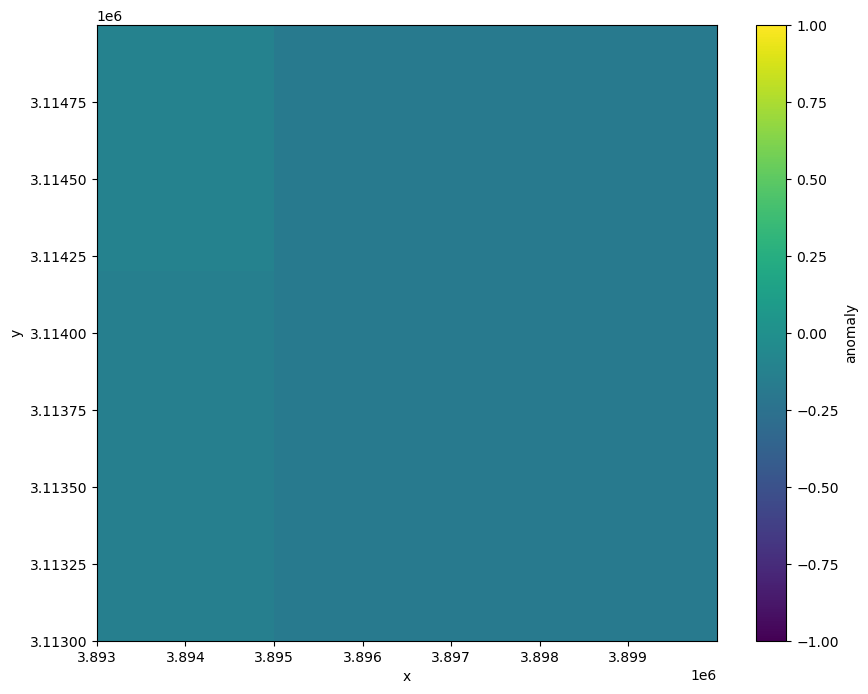

In [34]:
sma_SH["anomaly"].mean(axis=0).plot.imshow(figsize=(10,8), vmin=-1, vmax=1)
plt.show()

**Start of Season**

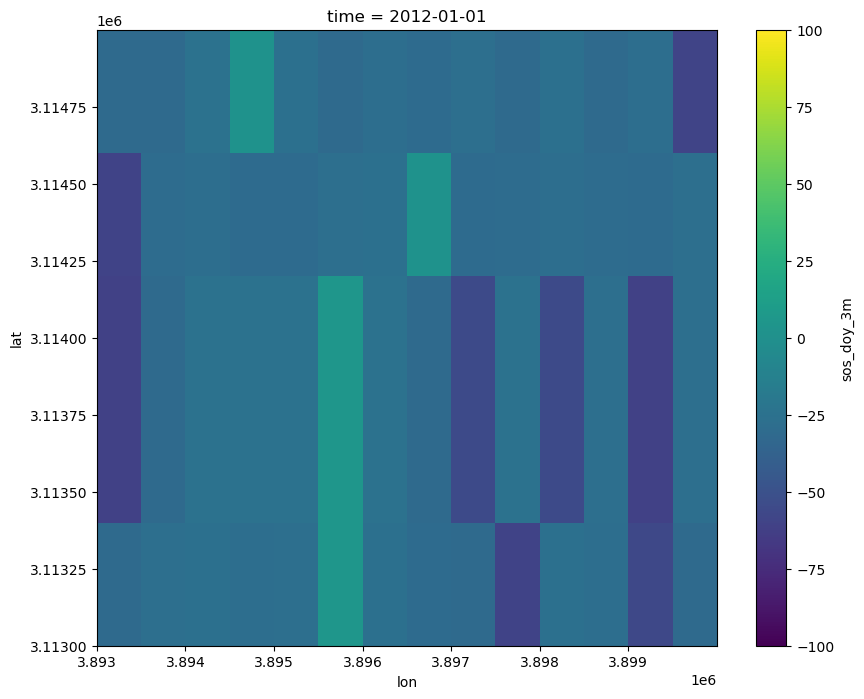

In [35]:
timesat_SH["sos_doy_3m"].isel(time=0).plot.imshow(figsize=(10,8), vmin=-100, vmax=100)
plt.show()

**End of Season**

## Comparison

Finally, we plot the SMA timeseries in the growing season for a given coordinate pair based on both methods.
Test plot the two methods for a given location

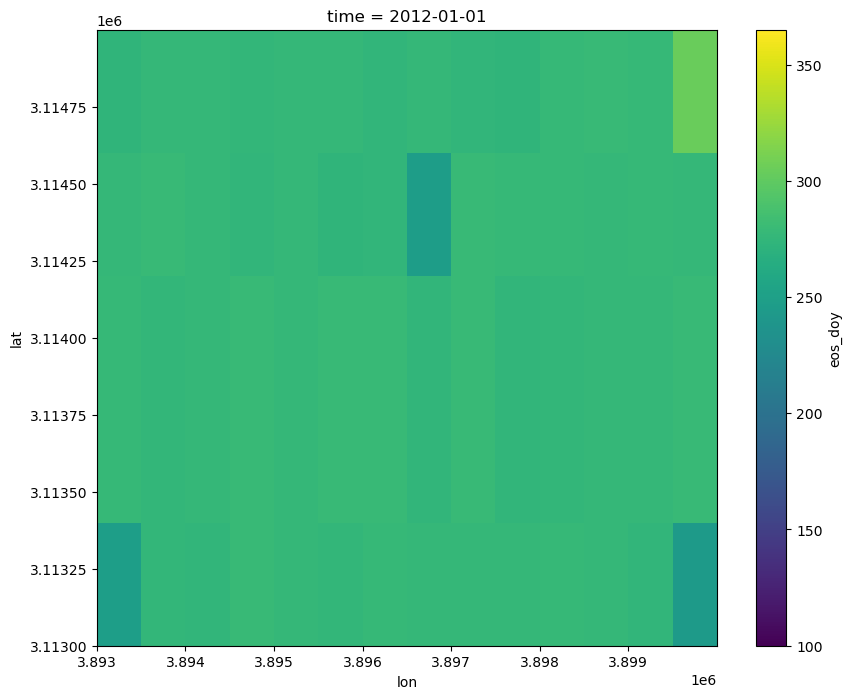

In [36]:
timesat_SH["eos_doy"].isel(time=0).plot.imshow(figsize=(10,8), vmin=100, vmax=365)
plt.show()

In [37]:
latitude = 3894000 # in EPSG:3035
longitude = 3107430 # in EPSG:3035

In this step we will compute the indices of SOS-3months and EOS for each pixel in the SMA datacube.

In [38]:
sampling_period_from_sos_to_eos(sma_SH.time.data, timesat_SH, method = 'SH')

In [39]:
def comparison_plot(sma_sh, sma_xcube, timesat_sh, timesat_xcube, year_comparison, latitude, longitude, years_names):
    fig, ax = plt.subplots(figsize=(12,8))
    index_year_cube = years_names.index(year_comparison)
    
    start_ind_year_sh = timesat_sh.isel(time = index_year_cube).sel(lat = latitude, lon = longitude, method = 'nearest')['SOS_start_ind'].values
    end_ind_year_sh = timesat_sh.isel(time = index_year_cube).sel(lat = latitude, lon = longitude, method = 'nearest')['EOS_start_ind'].values
    start_ind_year_xcube = timesat_xcube.isel(time = index_year_cube).sel(y = latitude, x = longitude, method = 'nearest')['SOS_start_ind'].values
    end_ind_year_xcube = timesat_xcube.isel(time = index_year_cube).sel(y = latitude, x = longitude, method = 'nearest')['EOS_start_ind'].values
    

    if np.isnan(start_ind_year_sh) or np.isnan(end_ind_year_sh):
        print('NO GS AVAILABLE FOR LOCATION')
        return []
    if np.isnan(start_ind_year_xcube) or np.isnan(end_ind_year_xcube):
        print('NO GS AVAILABLE FOR LOCATION')
        return []
    
    
    SMA_values_season_xcube = sma_xcube['anomaly_filtered'].sel(y = latitude, x = longitude, method = 'nearest')[int(start_ind_year_xcube): int(end_ind_year_xcube)+1]
    SMA_values_season_sh = sma_sh['anomaly'].sel(y = latitude, x = longitude, method = 'nearest')[int(end_ind_year_sh): int(start_ind_year_sh)+1]
    
    doys_xcube = [x.timetuple().tm_yday if x.year == year_comparison else x.timetuple().tm_yday-365 for x in pd.DatetimeIndex(SMA_values_season_xcube.time.data)]
    doys_sh = [x.timetuple().tm_yday if x.year == year_comparison else x.timetuple().tm_yday-365 for x in pd.DatetimeIndex(SMA_values_season_sh.time.data)]
    

    ax.plot(doys_sh, SMA_values_season_sh.values, color="forestgreen", label="SH", linestyle = '--')
    ax.plot(doys_xcube, SMA_values_season_xcube.values, color="red", label="Xcube")
    ax.legend()
    ax.set_xlabel("Day of Year [year {}]".format(str(year_comparison)))
    ax.set_ylabel("Soil moisture anomaly")
    ax.set_title("Comparison of soil moisture anomalies during the growing season of {} for both methods".format(str(year_comparison)))
    plt.show()

XCUBE SOS DAY IS: 1.0
SH SOS DAY IS: -31.0


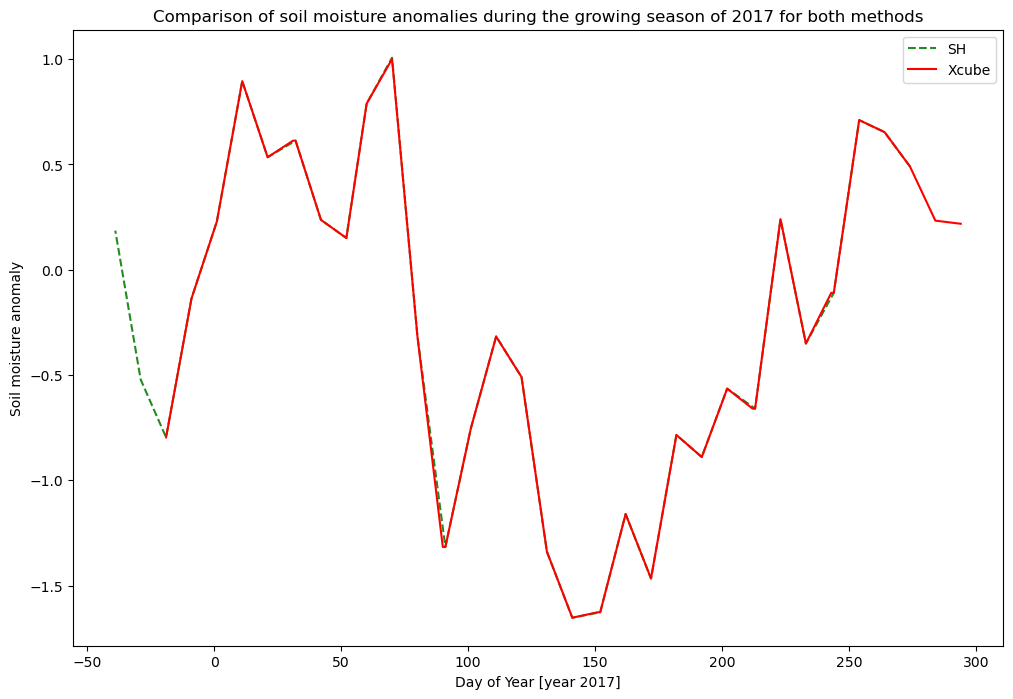

In [40]:
print('XCUBE SOS DAY IS: {}'.format(str(timesat_xcube['sos_doy_3m'].sel(y=latitude, x=longitude, method="nearest").values[0])))
print('SH SOS DAY IS: {}'.format(str(timesat_SH['sos_doy_3m'].sel(lat=latitude, lon=longitude, method="nearest").values[0])))
comparison_plot(sma_SH, sma_xcube, timesat_SH, timesat_xcube, 2017, latitude, longitude, years_names)

The small differences in the two curves are due to the interpolation in `xcube` over which the user has no control. We also notice that the SH curve includes more of data for the season. After thourough testing it appears that the method is correct in the `sentinelhub-py` version. If we choose to pursue with `xcube` the season selection bug will be fixed in the next iteration.

## Compute annual growing season anomaly

In the next cells the annual growing season anomaly will be determined by making use of the standardised SMA values. This **anomaly** will be calculated for **each growing season** seperately. 

In [41]:
def SMA_annual_anomaly(z_cube, sos_eos_cube, years_names, method = 'XCUBE'):
    """Calculate the SMA average wihtin the growing season for each year. 
    :param z_cube: the datacube with the SMA values
    :param sos_eos_cube: the datacube containing the index witht the SOS and EOS information for each year and each pixel in the SMA dataset
    :param years_names: the name of the years for which data is available
    :param method: specify if the datacube is retrieved by the XCUBE method or not. 
    :return: An Xarray dataarray with the SMA averages over each season (one later per year)
    """
    datasets  = {}
    lat, lon  =z_cube.y.values, z_cube.x.values

    sampling_period_from_sos_to_eos(z_cube.time.data, sos_eos_cube, method = method)
    SMA_avg_season = np.zeros_like(sos_eos_cube['sos'].compute().data)
    for year in years_names: #do this procedure for each year
        start_ind = sos_eos_cube['SOS_start_ind'].isel(time = years_names.index(year)).values
        end_ind = sos_eos_cube['EOS_start_ind'].isel(time = years_names.index(year)).values
        SMA_avg_season[years_names.index(year),:,:] =  mean_slice(z_cube["anomaly_filtered"].compute().data, start_ind, end_ind) # start and end index switched because of recent -> old order of time range

    datasets['SMA_average_season'] = xr.DataArray(data = SMA_avg_season, 
                                       dims = ['time', 'y','x'],
                                       coords = {'time': np.array([dt.datetime(item, 1, 1) for item in years_names]),'y': lat,'x': lon},
                                       attrs  = {'_FillValue': -9999})
    cube_annual = xr.Dataset(datasets)
    return cube_annual

In [42]:
sma_cube_xcube_annual_anomaly = SMA_annual_anomaly(sma_xcube, timesat_xcube, years_names_excl_2020)

In [43]:
#write this new dataset to a raster
outname_raster = 'Ann_SMA_avg' 
datatype = rio.float64
band_spec = 'ANNUAL AVERAGE SMA IN GS'
write_raster(aoi_coords_LAEA, sma_cube_xcube_annual_anomaly['SMA_average_season'], datatype, outname_raster, years_names_excl_2020,band_spec)

##### PLOT ANNUAL GROWING SEASON SOIL MOISTURE ANOMALIES

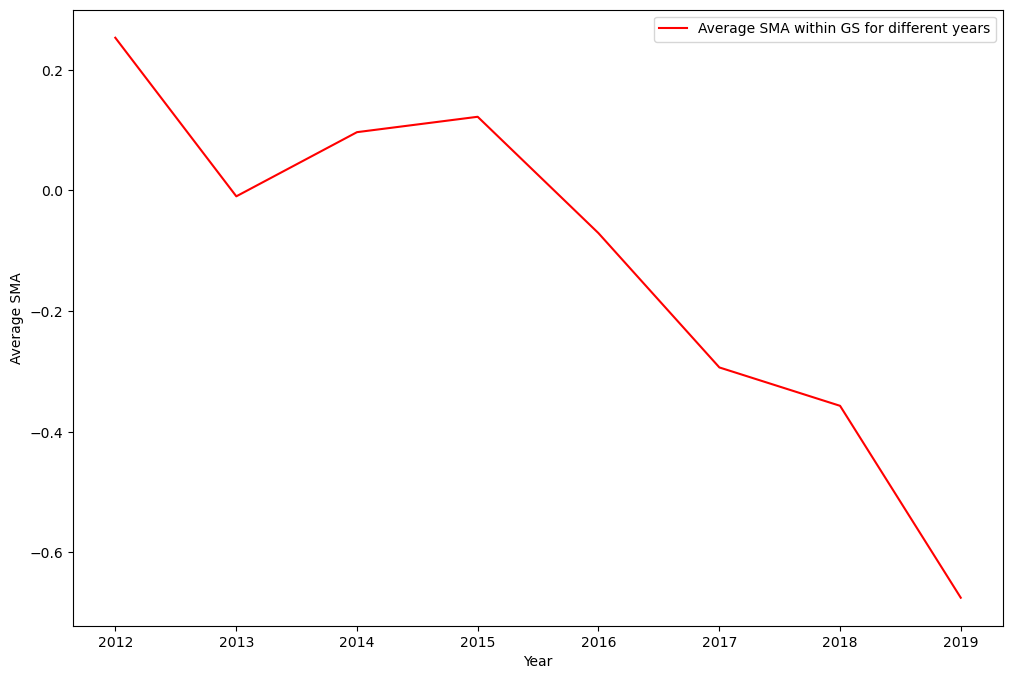

In [44]:
#take a random pixel
fig, ax = plt.subplots(figsize=(12,8))

sma_anomaly_years = sma_cube_xcube_annual_anomaly["SMA_average_season"]
sma_anomaly_years_pixel = sma_cube_xcube_annual_anomaly.sel(y=latitude, x=longitude, method="nearest")


years_sma_annual_anomaly = [x for x in pd.DatetimeIndex(sma_anomaly_years.time.data)]
ax.plot(years_sma_annual_anomaly, sma_anomaly_years_pixel["SMA_average_season"], color="red", label="Average SMA within GS for different years")
ax.legend(loc = 'upper right')
ax.set_xlabel("Year")
ax.set_ylabel("Average SMA")
plt.show()

## ANNUAL AND LONG-TERM AVERAGE DROUGHT INTENSITY

In a next step, the SMA values could be used to detect drought intensity for each growing season as well as long-term average drougth intensity 

In [45]:
def calc_annual_drought_intensity(cube_moisture, cube_phenology, years_names):
    """Calculate the annual drought intensity. 
    :param cube_moisture: the datacube with the SMA values
    :param cube_phenology: the datacube containing the index witht the SOS and EOS information for each year and each pixel in the SMA dataset
    :param years_names: the name of the years for which data is available
    :return: An Xarray dataarray with the annual drought intensity (one layer per year)
    """
    drought_intensity_values = np.zeros_like(cube_phenology['sos_doy_3m'].compute().data)
    for time in range(len(cube_phenology.time.data)):
        start_ind_season = cube_phenology.isel(time = time)['SOS_start_ind']
        end_ind_season = cube_phenology.isel(time = time)['EOS_start_ind']
        for i in range(drought_intensity_values.shape[1]):
            for j in range(drought_intensity_values.shape[2]):
                if not np.isnan(end_ind_season[i,j].values)  and not np.isnan(start_ind_season[i,j].values):
                    drought_intensity = np.nanmin(cube_moisture['anomaly_filtered'][int(start_ind_season[i,j].values):int(end_ind_season[i,j].values)+1,i,j])

                    if drought_intensity >= 0:
                        drought_intensity = 0
                else:
                    drought_intensity = np.nan
                drought_intensity_values[time, i, j] = drought_intensity
                
    cube_drought_intensity = xr.DataArray(drought_intensity_values, dims = ['time', 'y', 'x'], name = 'Annual drought intensity',
                                        coords = {'time': np.array([dt.datetime(item, 1, 1) for item in years_names]),'y': cube_phenology.y,'x': cube_phenology.x}) 
        
    return cube_drought_intensity 

In [46]:
annual_drought_intensity = calc_annual_drought_intensity(sma_xcube, timesat_xcube, years_names_excl_2020)
long_term_drought_intensity  = annual_drought_intensity.mean(axis = 0) # long-term drought is just taking the mean over the different year

#### Visualize annual drought intensity

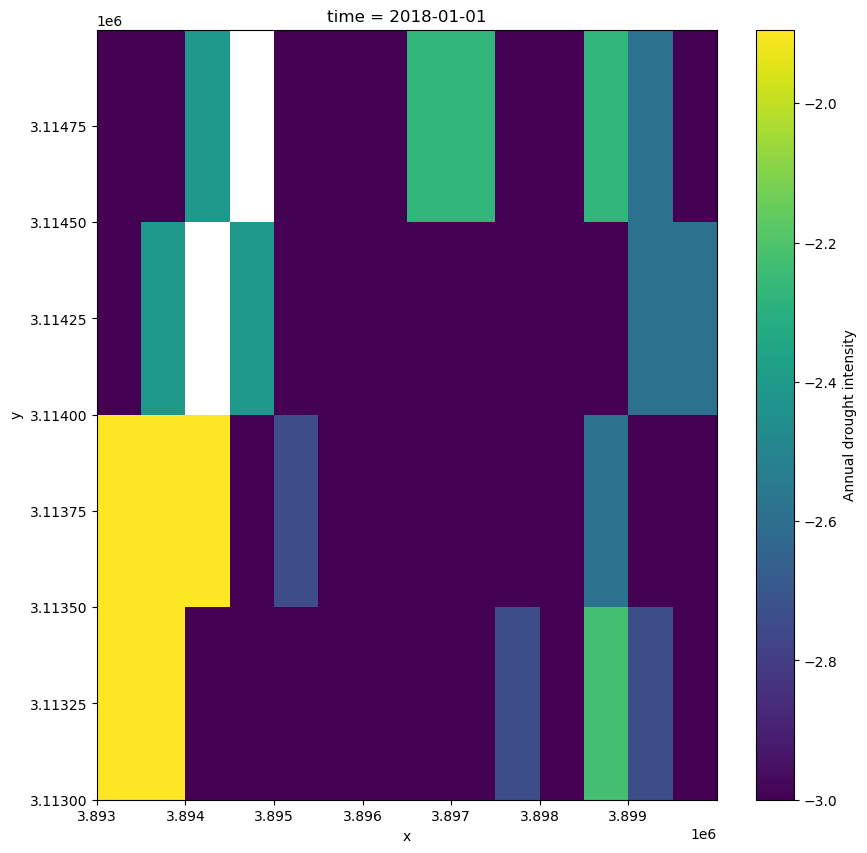

In [47]:
annual_drought_intensity.sel(time='2018-02-01 12:00:00', method='nearest').plot.imshow(figsize=(10, 10))
plt.show()

In [48]:
#write to raster
### annual drought intensity 
outname_raster = 'Ann_drought_intensity' 
datatype = rio.float64
band_spec = 'ANNUAL DROUGHT INTENSITY'
write_raster(aoi_coords_LAEA, annual_drought_intensity, datatype, outname_raster, years_names_excl_2020,band_spec)

### long-term drought intensity
outname_raster = 'Long_term_drought_intensity' 
datatype = rio.float64
band_spec = 'LONG TERM DROUGHT INTENSITY'
write_raster(aoi_coords_LAEA, long_term_drought_intensity, datatype, outname_raster, years_names_excl_2020,band_spec, multi_yrs= False)

## ANNUAL AND LONG-TERM AVERAGE DROUGHT HAZARD
Furthermore, SMA values could be used to detect the area under drought hazard. Therefore, in the next cells the pixels with SMA values below a certain threshold within the growing season will be aggregated on CLC level in a NUTS3 region.  

In [49]:
def determine_annual_drought_hazard(NUTS3_cube, CLC_cube, NUTS3_overlap_BBOX, years_names, yearly_strg_drought_hazard_interp):
    """
    Function used to count the pixel which are under strong drought hazard per NUTS3/CLC class and for each year
    :param NUTS3_cube: The NUT3 datacube containing the NUTS3 classes
    :param CLC_cube: The CLC datacube containing the land cover classification for the different years
    :param NUTS3_overlap_BBOX: list of NUTS3 IDS that indicate the overlapping regions within the BBOX
    :param years_names: list of all the years for which the drought hazard should be calculated
    :param yearly_strg_drought_hazard_interp: xarray containing binary info if drought hazard was present for a certain growing season for each pixel
    :return: a dataframe containing the amount of pixels with strong drought hazard for each year and NUTS3/CLC intersect
    """
    
    lst_df_drought_per_year = []
   
    for NUTS3 in NUTS3_overlap_BBOX: #loop over all the available NUTS3 regions
        lst_stats_year = []
        loc_NUTS3 = np.where(NUTS3_cube.boundaryEEA39.values[0,:,:] == NUTS3) #find location of this NUTS3 area within the cube
        for year in range(len(years_names)): #derive the stats for each year
            CLC_cube_year = CLC_cube.sel(time = '{}-01-01 12:00:00'.format(str(years_names[year])), method = 'nearest') #take the CLC layer closest to the actual year
            unique_CLC_classes = list(np.unique(CLC_cube_year.CLC.values[:,:][loc_NUTS3]))
            loc_CLC_classes = [np.where((CLC_cube_year.CLC[:,:].values == item)& 
                              (NUTS3_cube.boundaryEEA39.values[0,:,:] == NUTS3)) 
                               for item in unique_CLC_classes] #find the location of all CLC classes in the NUTS3 region
            
            
            check_if_drought_in_CLC = [yearly_strg_drought_hazard_interp.values[year,:,:][loc_CLC_classes[ix]] == 1 
                                         for ix in range(len(loc_CLC_classes))]
            count_drought_per_CLC = [sum(yearly_strg_drought_hazard_interp.values[year,:,:][loc_CLC_classes[ix]] == 1) 
                                     for ix in range(len(loc_CLC_classes))] #only consider the pixels under drought and count the amount of pixels
            df_strg_drought_hazard  = pd.DataFrame(data = count_drought_per_CLC, 
                                               columns = [years_names[year]], index = unique_CLC_classes) #put all the info into a dataframe
            df_strg_drought_hazard.index.name = 'CLC_class'
            df_strg_drought_hazard['NUTS3_ID'] = [NUTS3] * len(unique_CLC_classes)
            df_strg_drought_hazard = df_strg_drought_hazard.set_index('NUTS3_ID', append = True)
            lst_stats_year.append(df_strg_drought_hazard)

    df_final = pd.concat(lst_stats_year, axis = 1)
    return df_final


In [50]:
## Load the CLC layer and reproject to desired resolution
bands = ['CLC']
time_stamp = "1Y"
time_range=['2000-01-01', '2018-12-31'] #latest CLC is 2018
CLC_cube = create_xcube_data(bands, aoi_coords_LAEA, projection_code_LAEA, time_stamp, CLC_collection_id, sh_credentials, time_range, creodias = True, spatial_res = spatial_res_CLC)
# Temporary: get rid of empty days
CLC_cube = CLC_cube.dropna(dim="time")
# Remove nodata values
CLC_cube = CLC_cube.where(CLC_cube.CLC != 32768, drop=True)
CLC_cube = CLC_cube.where(CLC_cube.CLC != 0, drop=True) #ignore empty CLC years and focus on the years for which there is a CLC layer

/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


#### VISUALIZE CLC LAYER

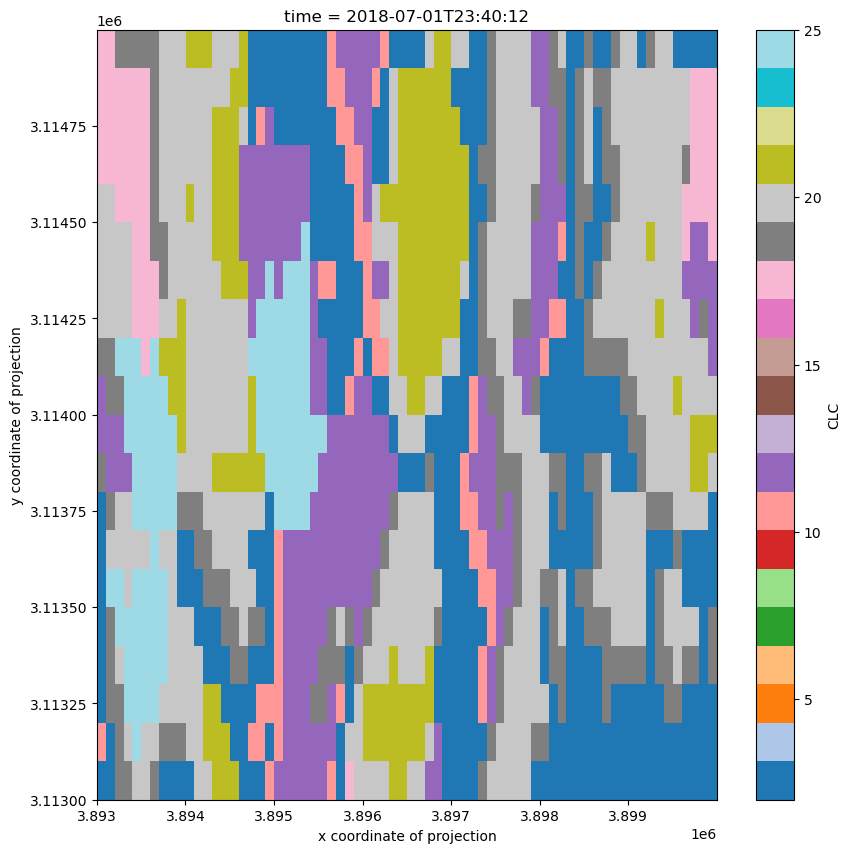

In [51]:
CLC_cube.sel(time='2018-02-01 12:00:00', method='nearest').CLC.plot.imshow(cmap="tab20", figsize=(10, 10))
plt.show()

In [52]:
# Load the NUTS3 regions via the XCUBE method
time_stamp = "1Y"
bands = ['boundaryEEA39']
time_range=['2020-01-01', '2020-12-31'] #only one layer whihc is stable over the years
NUTS3_cube = create_xcube_data(bands, aoi_coords_LAEA, projection_code_LAEA, time_stamp, NUTS3_collection_id, sh_credentials, time_range, spatial_res = spatial_res_CLC)
# Temporary: get rid of empty days
NUTS3_cube = NUTS3_cube.dropna(dim="time")

# Remove nodata values
NUTS3_cube = NUTS3_cube.where(NUTS3_cube.boundaryEEA39 != 65535, drop=True)
NUTS3_cube = NUTS3_cube.where(NUTS3_cube.boundaryEEA39 != 0, drop=True)
NUTS3_overlap_BBOX = [int(item) for item in list(np.unique(NUTS3_cube.boundaryEEA39.values))]

/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


#### VISUALIZE CLC LAYER

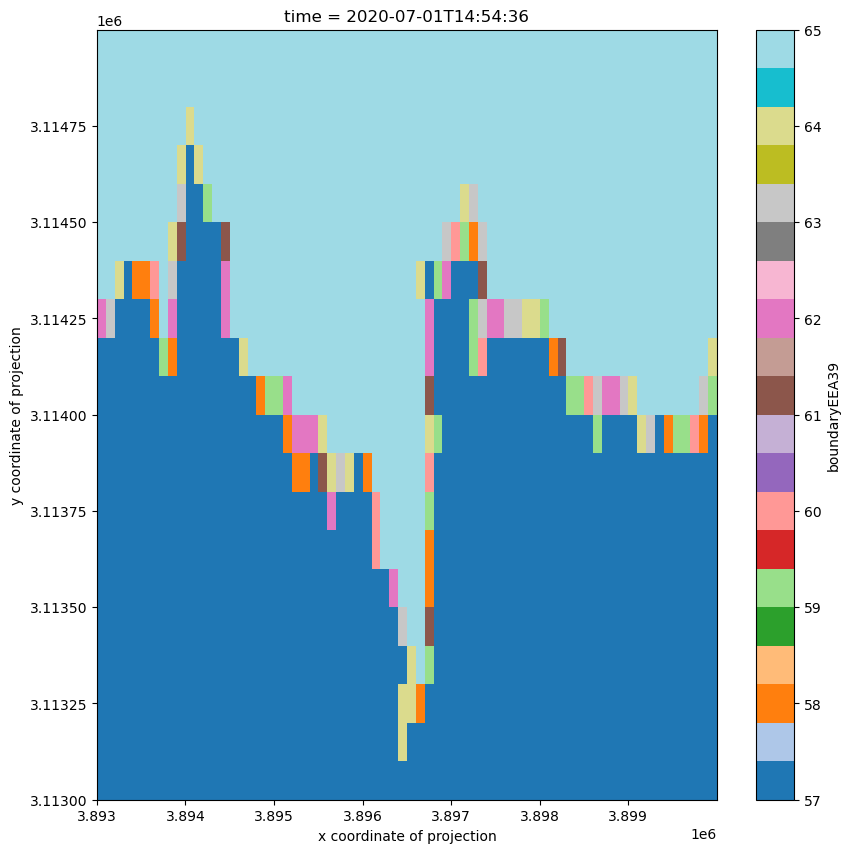

In [53]:
NUTS3_cube.sel(time='2018-02-01 12:00:00', method='nearest').boundaryEEA39.plot.imshow(cmap="tab20", figsize=(10, 10))
plt.show()

In [54]:
#first convert the SMA values over the years to binary values
loc_no_GS = np.where(np.isnan(annual_drought_intensity))
strg_drought_hazard = np.where(annual_drought_intensity <= -1,1,0) #pixels with a drought intensity lower than -1 are considered under drought hazard, the others not 
strg_drought_hazard[loc_no_GS]  =-1 #the pixels with no season are ignored
yearly_strg_drought_hazard =xr.DataArray(strg_drought_hazard, dims = ['time', 'y', 'x'], name = 'Annual strong drought hazard',
                                        coords = {'time': np.array([dt.datetime(item, 1, 1) for item in years_names_excl_2020])
                                                  ,'y': timesat_xcube.y,'x': timesat_xcube.x}).astype(np.byte) #create dataarray of yearly strong drought hazard

#### Visualize strong drought hazard

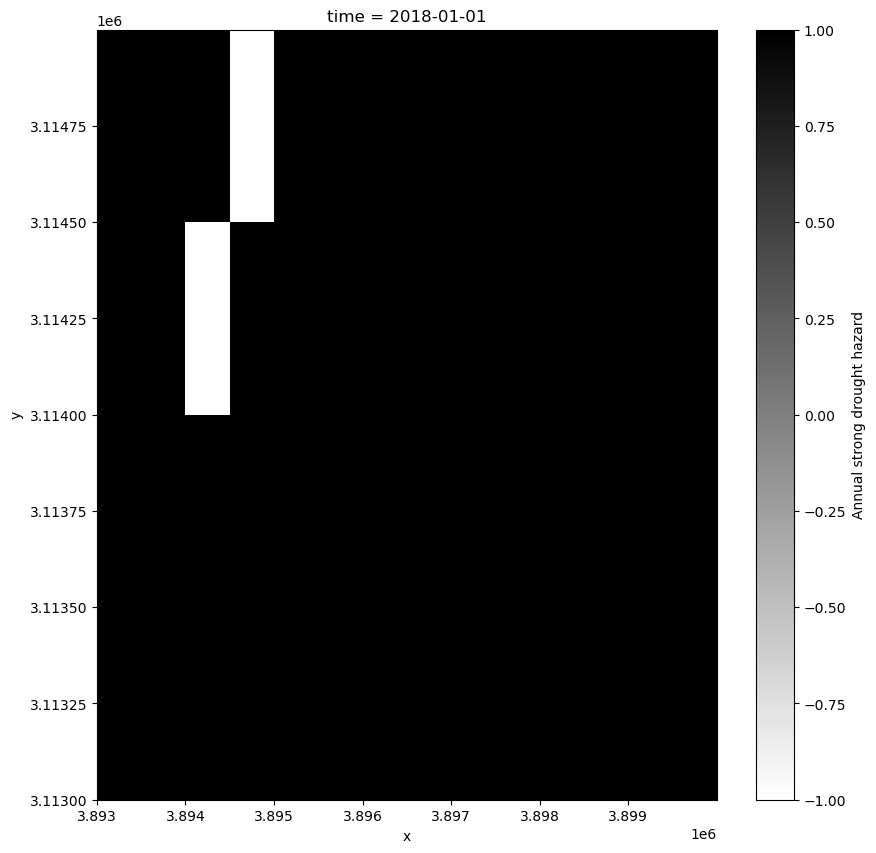

In [55]:
yearly_strg_drought_hazard.sel(time='2018-02-01 12:00:00', method='nearest').plot.imshow(cmap = 'binary',figsize=(10, 10))
plt.show()

In [56]:
# The strong drought hazard neeed to be converted to the same resolution as the CLC layer
yearly_strg_drought_hazard_interp = interpolate_xarray(CLC_cube, yearly_strg_drought_hazard)

#### ANNUAL DROUGHT HAZARD 

In [57]:
# determine the area under drought hazard for each NUTS3/CLC intersect
df_annual_drought_hazard = determine_annual_drought_hazard(NUTS3_cube, CLC_cube, NUTS3_overlap_BBOX, years_names_excl_2020, yearly_strg_drought_hazard_interp)   
df_annual_drought_hazard.to_csv(os.path.join(output_folder_csv.absolute().as_posix(), 'df_annual_drought_hazard.csv'), index = True)

#### LONG-TERM AVERAGE AREA OF DROUGHT HAZARD

In [58]:
df_long_term_drough_avg_area = pd.DataFrame(df_annual_drought_hazard.mean(axis = 1)) #just take the mean
df_long_term_drough_avg_area = df_long_term_drough_avg_area.rename(columns = {0: 'avg_drought_area'})
df_long_term_drough_avg_area.to_csv(os.path.join(output_folder_csv.absolute().as_posix(), 'df_long_term_drough_avg_area.csv'), index = True)

## ANNUAL AND LONG-TERM AVERAGE DROUGHT HAZARD FREQUENCY

Above we defined the area under strong drought hazard. On the other hand, the occurence of strong negative SMA within the growing season can also be calculated on pixel level. In this way, you can have some idea on the drought hazard frequency on a yearly basis and/or on a longer time scale. 

In [59]:
def calc_annual_drought_hazard_freq(cube_moisture, cube_phenology, years_names):
    """
    Function used to calculate the number of times strong drought hazard occur within the growing season. This is done on a yearly basis. 
    :param cube_moisture: The datacube containing the SMA. 
    :param cube_phenology: the datacube containing the index witht the SOS and EOS information for each year and each pixel in the SMA dataset
    :param years_names: list of all the years for which the drought hazard should be calculated
    :return: An Xarray dataarray with the frequency of drought hazard for each year
    """
    ann_drought_hzrd_freq = np.zeros_like(cube_phenology['sos_doy_3m'].compute().data).astype(np.int8)
    for time in range(len(cube_phenology.time.data)):
        start_ind_season = cube_phenology.isel(time = time)['SOS_start_ind']
        end_ind_season = cube_phenology.isel(time = time)['EOS_start_ind']
        for i in range(ann_drought_hzrd_freq.shape[1]):
            for j in range(ann_drought_hzrd_freq.shape[2]):
                if not np.isnan(end_ind_season[i,j].values)  and not np.isnan(start_ind_season[i,j].values):
                    drought_hzrd_freq = len(np.where(cube_moisture['anomaly_filtered'][int(end_ind_season[i,j].values):int(start_ind_season[i,j].values)+1,i,j] <=-1)[0])
                else:
                    drought_hzrd_freq = -1 #the pixels with no seasonality data are set to a nodata value
                ann_drought_hzrd_freq[time, i, j] = drought_hzrd_freq
                
    cube_ann_hzrd_freq = xr.DataArray(ann_drought_hzrd_freq, dims = ['time', 'y', 'x'], name = 'Annual drought hazard frequency',
                                        coords = {'time': np.array([dt.datetime(item, 1, 1) for item in years_names]),'y': cube_phenology.y,'x': cube_phenology.x}) 
    return cube_ann_hzrd_freq 

#### Annual drought hazard frequency

In [60]:
annual_hazard_frequency = calc_annual_drought_hazard_freq(sma_xcube, timesat_xcube, years_names_excl_2020)

#### Visualize annual hazard frequency

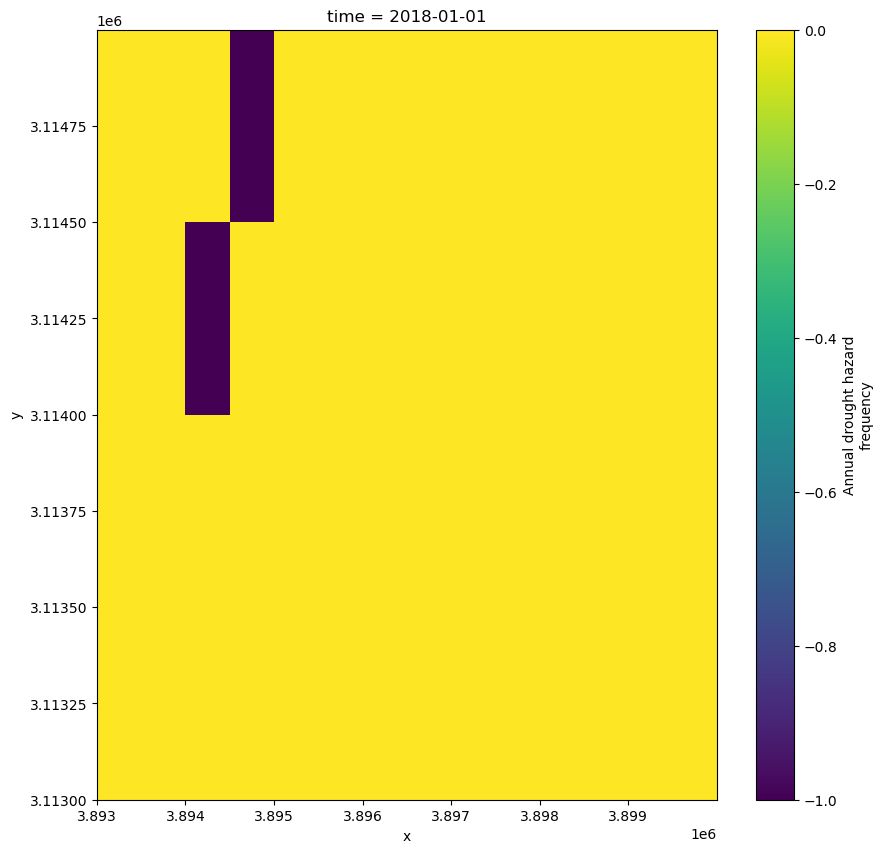

In [61]:
annual_hazard_frequency.sel(time='2018-02-01 12:00:00', method='nearest').plot.imshow(figsize=(10, 10))
plt.show()

In [62]:
#write to raster
outname_raster = 'Ann_drought_hzrd_freq' 
datatype = rio.int8
band_spec = 'ANNUAL DROUGHT FREQUENCY'
write_raster(aoi_coords_LAEA, annual_hazard_frequency, datatype, outname_raster, years_names_excl_2020,band_spec)

#### Long-term average drought hazard frequency

In [63]:
#only focus on the years with a growing season to take the average over the years
nr_years_season =  annual_hazard_frequency.where(annual_hazard_frequency >= 0, drop=True).count(axis = 0)
count_drought_hzrd_freq_season = annual_hazard_frequency.where(annual_hazard_frequency >= 0, drop=True).sum(axis = 0, skipna = True) #total count of drought hazard over all the years
long_term_avg_drought_hzrd_freq = count_drought_hzrd_freq_season/nr_years_season

#write to raster
datatype = rio.float64
outname_raster = 'long_term_avg_drought_hzrd_freq' 
band_spec = 'AVERAGE DROUGHT HAZARD FREQUENCY'
write_raster(aoi_coords_LAEA, long_term_avg_drought_hzrd_freq, datatype, outname_raster, years_names_excl_2020, band_spec, multi_yrs=False)

## HR-VPP indices for drought monitoring

In the next cells, the HR-VPP data will be used to generate some additional drought indicators like drought pressure and impact 

### REQUEST NECCESARY HR-VPP DATA


#### Open Seasonal Trajectories cube

In [64]:
bands_ST = ['PPI']
time_range = ['2017-01-01','2020-12-31']
time_stamp = '10d'
ST_cube = create_xcube_data(bands_ST, aoi_coords_LAEA, projection_code_LAEA, time_stamp, st_collection, sh_credentials, time_range, creodias = True, spatial_res = spatial_res_HRVPP).dropna(dim="time")
ST_cube = ST_cube.where(ST_cube.PPI != 32768, drop=True)

#### Open VPP parameters cube

In [65]:
bands_VPP = ['SOSD', 'EOSD','TPROD', 'SPROD', 'LENGTH', 'MAXV',] 
time_stamp = '1Y'
time_range = ['2017-01-01','2020-12-31']
VPP_cube_S1 = create_xcube_data(bands_VPP, aoi_coords_LAEA, projection_code_LAEA, time_stamp, vpp_s1_collection, sh_credentials, time_range, creodias = True, spatial_res = spatial_res_HRVPP).dropna(dim="time")
VPP_cube_S2 = create_xcube_data(bands_VPP, aoi_coords_LAEA, projection_code_LAEA, time_stamp, vpp_s2_collection, sh_credentials, time_range, creodias = True, spatial_res = spatial_res_HRVPP).dropna(dim="time")
VPP_cube_S1 = VPP_cube_S1.where(VPP_cube_S1.SOSD != 0, drop=True)
VPP_cube_S2 = VPP_cube_S2.where(VPP_cube_S2.SOSD != 0, drop=True)

/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)
/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/pandas/core/tools/timedeltas.py:132: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  return _coerce_scalar_to_timedelta_type(arg, unit=unit, errors=errors)


### VISUALIZE ST

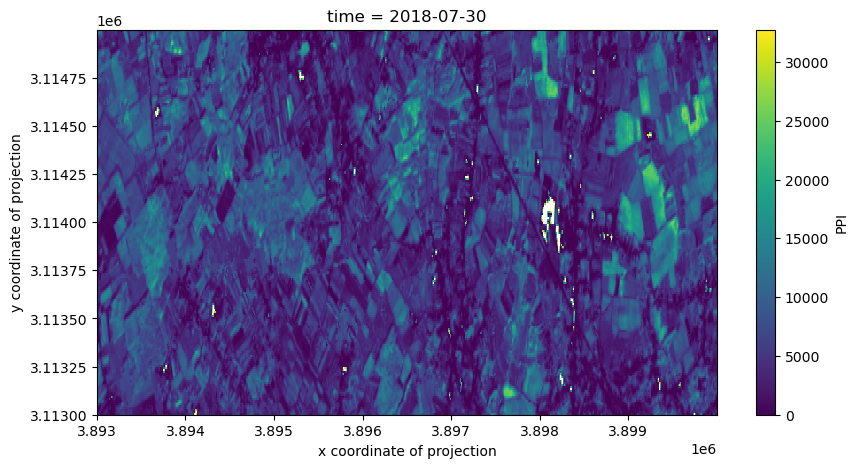

In [66]:
ST_cube.PPI.sel(time='2018-08-01 12:00:00', method='nearest').plot.imshow(figsize=(10, 5))
plt.show()

#### VISUALIZE VPP SEASON 1

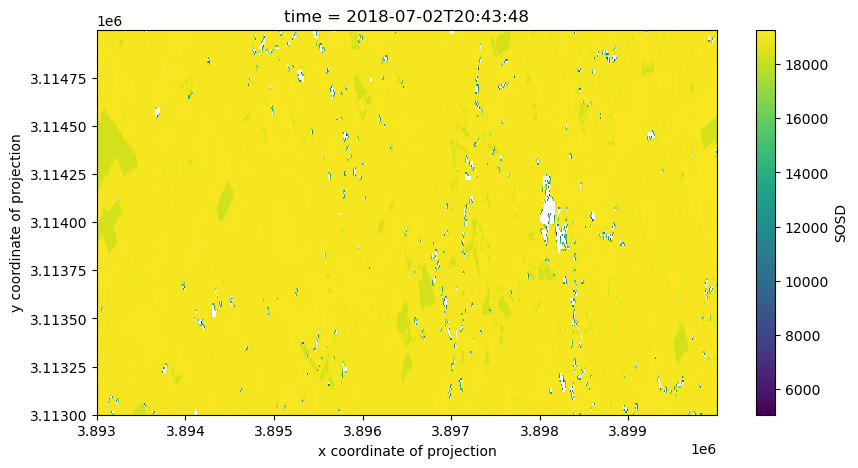

[[19064. 19065. 19066. ... 19090. 19091. 19082.]
 [19066. 19065. 19065. ... 19067. 19071. 19061.]
 [19069. 19067. 19067. ... 19059. 19063. 19067.]
 ...
 [19099. 19110. 19124. ... 19030. 19063. 19065.]
 [19098. 19111. 19120. ... 19081. 19080. 19074.]
 [19099. 19090. 19090. ... 19079. 19082. 19078.]]


In [67]:
VPP_cube_S1.SOSD.sel(time='2018-08-01 12:00:00', method='nearest').plot.imshow(figsize=(10, 5))
plt.show()
print(VPP_cube_S1.SOSD.sel(time='2018-08-01 12:00:00', method='nearest').values)

#### WRITE AN EXAMPLE OF HR-VPP DATA TO A RASTER 

In [68]:
#write to raster
outname_raster = 'VPP_S1' 
datatype = rio.uint16
band_spec = 'SOSD'
write_raster(aoi_coords_LAEA,VPP_cube_S1['SOSD'], datatype, outname_raster, ['2017','2018','2019'],band_spec, multi_yrs= True, multi_obs_yr= True, EPSG= 3035)

#### Drought pressure

##### First align the resolutions

In [69]:
## convert the SMA datacube to the same resolution as HR-VPP (500 -> 10 m)
yearly_strg_drought_hazard_10m = interpolate_xarray(ST_cube, yearly_strg_drought_hazard).astype(rio.float32)

In [70]:
#write the drought hazard at 10m to a raster
outname_raster = 'Drought_hazard_10M' 
datatype = rio.float32
band_spec = 'Drought_hazard'
write_raster(aoi_coords_LAEA,yearly_strg_drought_hazard_10m, datatype, outname_raster,years_names, band_spec, multi_yrs= True, multi_obs_yr= True, EPSG= 3035)

### START THE AGGREGATION OF THE HR-VPP INDICES

In [71]:
def calc_stats_class(cube_stats, band_stats, loc_stats, drought_pressure_cube, year, method = 'count'):
    """
    Calculation of the stats within a certain location 
    :param cube_stats: datacube on which the stats should be calculated
    :param band_stats: the band 'variabele' of the datacube on which the stats should be calculated
    :param loc_stats: filtered location (based on aggregation) which will be used to derive the stats
    :param ST_cube: the datacube containing the ST 
    :param drought_pressure_cube: the datacube containing the areas which are under drought pressure for each year
    :param years: Year for which the stats should be derived
    :param method: the kind of statistic used to calculate within the specific area
    :return: the value that returns from the statistical method
    """
    if method == 'count':
        stats = sum(cube_stats.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest')[band_stats].values[loc_stats])
    elif method == 'mean':
        stats = np.nanmean(cube_stats.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest')[band_stats].values[loc_stats])
    elif method == 'median':
        stats = np.nanmedian(cube_stats.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest')[band_stats].values[loc_stats])
    elif method == 'std':
        stats = np.nanstd(cube_stats.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest')[band_stats].values[loc_stats])
    return stats

def aggregate_drought_pressure(dict_datasets_bands, VPP_S1_cube, VPP_S2_cube, ST_cube, drought_pressure_cube, dict_layers_aggreg, years_HRVPP, drought = True):
    """
     Agrgegation of the HR-VPP layers based on defined aggregation layers for areas under drought or no drought 
    :param dict_datasets_bands: band names for each collection on which the aggregation will be done.
    :param VPP_S1_cube: the datacube containing VPP data of season 1
    :param VPP_S2_cube: the datacube containing VPP data of season 2
    :param ST_cube: the datacube containing the ST 
    :param drought_pressure_cube: the datacube containing the areas which are under drought pressure for each year
    :param dict_layers_aggreg: the layers which will be used to do the aggregation on. Disclaimer: max 2 layers are supported. 
    :param years_HRVPP: list of all the years for which the HR-VPP stats should be calculated. #options between 2017-2020
    :return: A dataframe with the stats for each aggregation level
    """
    #first check if the dimensions of the aggregation and HR-VPP layers are identical. Otherwise, intperpolate
    for layer_key in dict_aggregation_layer.keys():
        if len(dict_aggregation_layer.get(layer_key).x.values) != len(VPP_S1_cube.x.values) or len(dict_aggregation_layer.get(layer_key).y.values) != len(VPP_S1_cube.y.values):
            print("interpolation needed")
            dict_aggregation_layer.update({layer_key:  interpolate_xarray(VPP_S1_cube, dict_aggregation_layer.get(layer_key))})
    lst_stats_class_layer1 = []
    for year in years_HRVPP: #do the computation for each year
        layer1_select_aggreg = next(iter(dict_layers_aggreg.values()))
        layer1_key_select_aggreg = list(dict_layers_aggreg.keys())[0]
        name_band = layer1_select_aggreg.attrs.get('history')[0].get('cube_config').get('band_names')[0]
        layer1_select_aggreg_year = layer1_select_aggreg.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest')
        unique_classes_aggreg_layer1 = list(np.unique(layer1_select_aggreg_year[name_band].values))
        unique_classes_aggreg_layer1 = [item for item in unique_classes_aggreg_layer1 if not str(item) == 'nan']
        for class_layer1 in unique_classes_aggreg_layer1:            
            if drought:
                loc_stats =  np.where(np.logical_and(layer1_select_aggreg_year[name_band].values == class_layer1 ,
                                              drought_pressure_cube.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest').values == 1))
            else:
                 loc_stats =  np.where(np.logical_and(layer1_select_aggreg_year[name_band].values == class_layer1 ,
                                              drought_pressure_cube.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest').values == 0))
                
            if len(dict_layers_aggreg.keys())>1:
                layer2_key_select_aggreg  = list(dict_layers_aggreg.keys())[-1]
                layer2_select_aggreg = dict_layers_aggreg.get(layer2_key_select_aggreg)
                name_band_layer2 = layer2_select_aggreg.attrs.get('history')[0].get('cube_config').get('band_names')[0]
                layer2_select_aggreg_year = layer2_select_aggreg.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest')
                unique_layer2_classes = list(np.unique(layer2_select_aggreg_year[name_band_layer2].values[loc_stats]))
            else:
                layer2_key_select_aggreg = 'No_layer'
                unique_layer2_classes = [None]
            for class_layer2 in unique_layer2_classes:
                if class_layer2 != None:
                    if drought == True:
                        loc_stats_layer2 = [np.where((layer2_select_aggreg_year[name_band_layer2].values == class_layer2) & (layer1_select_aggreg_year[name_band].values == class_layer1)
                                            &(drought_pressure_cube.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest').values == 1))][0]

                    else:
                        loc_stats_layer2 = [np.where((layer2_select_aggreg_year[name_band_layer2].values == class_layer2) & (layer1_select_aggreg_year[name_band].values == class_layer1)
                                           & (drought_pressure_cube.sel(time = '{}-01-01 12:00:00'.format(str(year)), method = 'nearest').values == 0))][0]
                        
                else:
                    loc_stats = loc_stats_layer2
                    
                dict_stats_VPP_layers  = {}
                for HRVPP_dataset in dict_datasets_bands.keys():
                    bands_dataset = dict_datasets_bands.get(HRVPP_dataset)
                    if 'S1' in HRVPP_dataset:
                        HRVPP_cube = VPP_S1_cube
                    elif 'S2' in HRVPP_dataset:
                        HRVPP_cube = VPP_S2_cube
                    else:
                        HRVPP_cube = ST_cube
                    for HRVPP_band in bands_dataset:
                        stats_aggreg_HRVPP_data =  calc_stats_class(HRVPP_cube,str(HRVPP_band), loc_stats_layer2, drought_pressure_cube, year, method = 'median')
                        dict_stats_VPP_layers.update({HRVPP_band: stats_aggreg_HRVPP_data})
                    df_tmp = pd.DataFrame.from_dict(dict_stats_VPP_layers, orient = 'index').T
                    df_tmp['year'] = [year] * (df_tmp.shape[0])
                    df_tmp['{}_class'.format(layer1_key_select_aggreg)] = [class_layer1] * (df_tmp.shape[0])
                    df_tmp['{}_class'.format(layer2_key_select_aggreg)] = [class_layer2] * (df_tmp.shape[0])

                
                    lst_stats_class_layer1.append(df_tmp)
    if not lst_stats_class_layer1:
        return pd.DataFrame()
    df_stats = pd.concat(lst_stats_class_layer1)
    return df_stats

In [72]:
### Define the bands names for each HR-VPP layer
dict_datasets_bands = {'VPP_S1': bands_VPP,
                       'VPP_S2': bands_VPP,
                          'ST': bands_ST}

#Define which layers will be used to the aggregation. The intersection of the first layer with the second one will be used to derive the stats within this intersection.
dict_aggregation_layer = {'NUTS3': NUTS3_cube,
                          'CLC': CLC_cube} 

In [73]:
#derive stats for areas under drought 
df_stats_drought = aggregate_drought_pressure(dict_datasets_bands, VPP_cube_S1, VPP_cube_S2, ST_cube, 
                                              yearly_strg_drought_hazard_10m, dict_aggregation_layer, ['2017','2018','2019'])

#derive stats for areas without drought
df_stats_no_drought = aggregate_drought_pressure(dict_datasets_bands, VPP_cube_S1, VPP_cube_S2, ST_cube, 
                                                 yearly_strg_drought_hazard_10m, dict_aggregation_layer, ['2017','2018','2019'], drought = False)

##Save the result into a csv
df_stats_drought.to_csv(os.path.join(output_folder_csv.absolute().as_posix(), 'df_stats_drought_HRVPP.csv'))
df_stats_no_drought.to_csv(os.path.join(output_folder_csv.absolute().as_posix(), 'df_stats_no_drought_HRVPP.csv'))

interpolation needed
interpolation needed


/opt/conda/envs/eurodatacube-0.24.5/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [74]:
#### ADD ST WITHIN GROWING SEASON FOR STATS CALCULATION
